The data team at Waze is more than halfway through their project for developing a machine learning model to predict user churn. Earlier, you completed a project proposal, used Python to explore and analyze Waze’s user data, created data visualizations, and conducted a hypothesis test. Now, leadership wants your team to build a regression model to predict user churn based on a variety of variables.

Ursula Sayo, the Operations Manager at Waze. Ursula asks your team about the details of the regression model. You also notice two follow-up emails from your supervisor, May Santner. The first email is a response to Ursula, and says that the team will build a binomial logistic regression model. In her second email, May asks you to help build the model and prepare an executive summary to share your results.

In [106]:
import exploratory_data_analysis.eda_functions as eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
## metrics
from sklearn.metrics import accuracy_score,\
recall_score, precision_score, f1_score,\
confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.utils import resample

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import scipy
from scipy import stats
from scipy.stats.mstats import winsorize

import warnings as cuidado
cuidado.filterwarnings('ignore')

In [107]:
df = pd.read_csv('waze_dataset.csv')
df.drop(['ID'], inplace=True, axis=1)

In [108]:
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [109]:
##EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
dtypes: float64(3), int64(7), object(2)
memory usage: 1.4+ MB


In [162]:
len(df[df['label'] =='churned']) / 14299, len(df[df['label'] =='retained']) / 14299, (len(df[df['label'] =='churned']) / 14299) +(len(df[df['label'] =='retained']) / 14299)

(0.17735505979439123, 0.8226449402056087, 1.0)

In [161]:
df[pd.isnull(df['label'])]

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
77,NaN,4.158883,3.931826,4.898617,783,5.308268,0.000000,7.882321,7.325287,19,13,iPhone
80,NaN,4.762174,4.543295,6.080071,1584,5.648974,4.143135,8.339121,8.046514,18,15,iPhone
98,NaN,4.369448,4.174387,6.121528,3414,0.000000,0.000000,7.502264,6.466439,12,11,Android
111,NaN,4.672829,4.634729,4.739518,2228,2.708050,0.000000,7.943954,7.607244,17,13,Android
142,NaN,3.496508,3.295837,5.407751,208,4.025352,2.397895,7.808248,6.774712,11,7,iPhone
...,...,...,...,...,...,...,...,...,...,...,...,...
14941,NaN,5.257495,5.081404,6.121528,1287,3.258097,0.000000,8.774805,8.151075,14,14,iPhone
14943,NaN,3.891820,3.663562,4.582894,555,0.000000,1.945910,9.020043,8.449059,19,19,iPhone
14945,NaN,3.555348,3.401197,4.908356,1643,5.594711,1.098612,8.423983,7.365314,18,17,Android
14972,NaN,5.398163,5.204007,5.549901,1718,5.888878,3.178054,8.628361,8.320068,19,18,iPhone


In [113]:
## Unique elements per column
[len(df[i].unique()) for i in df.columns]

[3, 469, 401, 14999, 3441, 730, 287, 14999, 14999, 32, 31, 2]

In [114]:
## three classes ???
df['label'].unique()

array(['retained', 'churned', nan], dtype=object)

In [115]:
## observing missing values and invalid values
#help(eda.get_invalid_values)
eda.get_invalid_values(df).iloc[:, 1:]

,nulls,invalids,unique_item
label,700,700,"[retained, churned, nan]"
sessions,0,0,"[283, 133, 114, 49, 84, 113, 3, 39, 57, 23, 12..."
drives,0,0,"[226, 107, 95, 40, 68, 103, 2, 35, 46, 20, 100..."
total_sessions,0,0,"[296.7482729, 326.8965962, 135.5229263, 67.589..."
n_days_after_onboarding,0,0,"[2276, 1225, 2651, 15, 1562, 2637, 360, 2999, ..."
total_navigations_fav1,0,0,"[208, 19, 0, 322, 166, 185, 72, 3, 64, 39, 54,..."
total_navigations_fav2,0,0,"[0, 64, 7, 5, 18, 26, 36, 16, 24, 19, 90, 11, ..."
driven_km_drives,0,0,"[2628.845068, 13715.92055, 3059.148818, 913.59..."
duration_minutes_drives,0,0,"[1985.775061, 3160.472914, 1610.735904, 587.19..."
activity_days,0,0,"[28, 13, 14, 7, 27, 15, 22, 25, 9, 1, 12, 0, 1..."


In [116]:
## count of the target.
df['label'].value_counts()

retained    11763
churned      2536
Name: label, dtype: int64

In [117]:
## Data by data type.
nums = eda.sift_data_type(df)['nums']
cats = eda.sift_data_type(df)['objs']

In [118]:
## cats

df['label'].value_counts()

retained    11763
churned      2536
Name: label, dtype: int64

------- CLASS COUNTS --------------------

---------LABEL--------------------
retained    11763
churned      2536
Name: label, dtype: int64
2536, is: 17.7355% of the total
11763, is: 82.2645% of the total
not balance, unfortunately This is not the way
------------------------------------------
count        14299
unique           2
top       retained
freq         11763
Name: label, dtype: object
------------------------------------------
---------DEVICE--------------------
iPhone     9672
Android    5327
Name: device, dtype: int64
5327, is: 35.5157% of the total
9672, is: 64.4843% of the total
not balance, unfortunately This is not the way
------------------------------------------
count      14999
unique         2
top       iPhone
freq        9672
Name: device, dtype: object
------------------------------------------


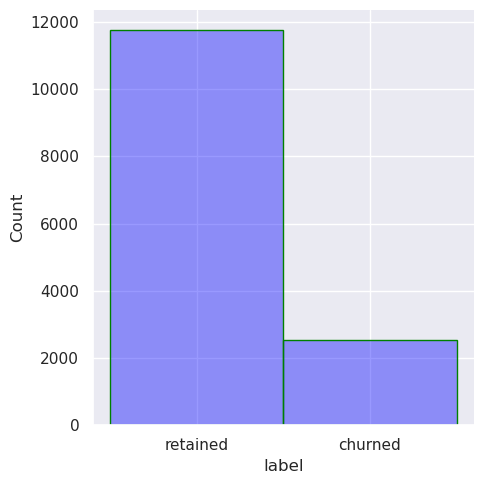

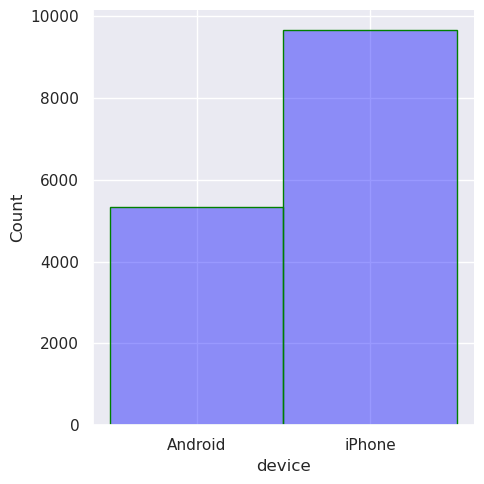

In [119]:
## Balance checking

def pct_checker(percentage, min_percentage, max_percentage):
    if percentage >= min_percentage and percentage <= max_percentage:
        return ('This is the way, balance')
    else:
        return ('not balance, unfortunately This is not the way')

print('------- CLASS COUNTS --------------------')
print()
for obj in cats:
    sns.displot(df, x=obj, color='blue', edgecolor='green', alpha=0.4)
    print(f'---------{str.upper(obj)}--------------------')
    print(df[obj].value_counts())
    
    a = df[obj].value_counts()[0]
    b = df[obj].value_counts()[1]
    pct_a = a / ( a + b ) * 100
    pct_b = b / ( a + b ) * 100
    
    print(f'{b}, is: {round(pct_b, 4)}% of the total')
    print(f'{a}, is: {round(pct_a, 4)}% of the total')
    
    ##
    ## As pct depend of each other we just need one check
    print(pct_checker(pct_a, 40, 60))
 
    print('------------------------------------------')
    print(df[obj].describe())
    print('------------------------------------------')

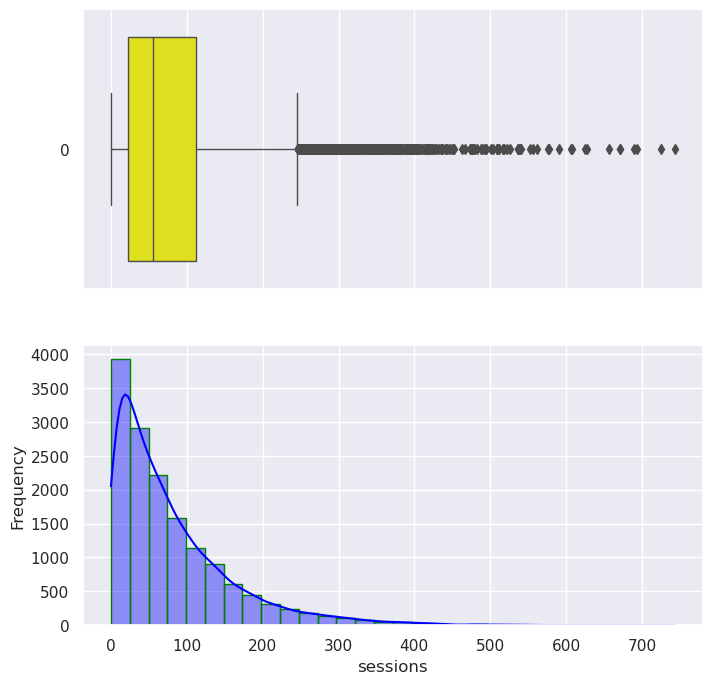

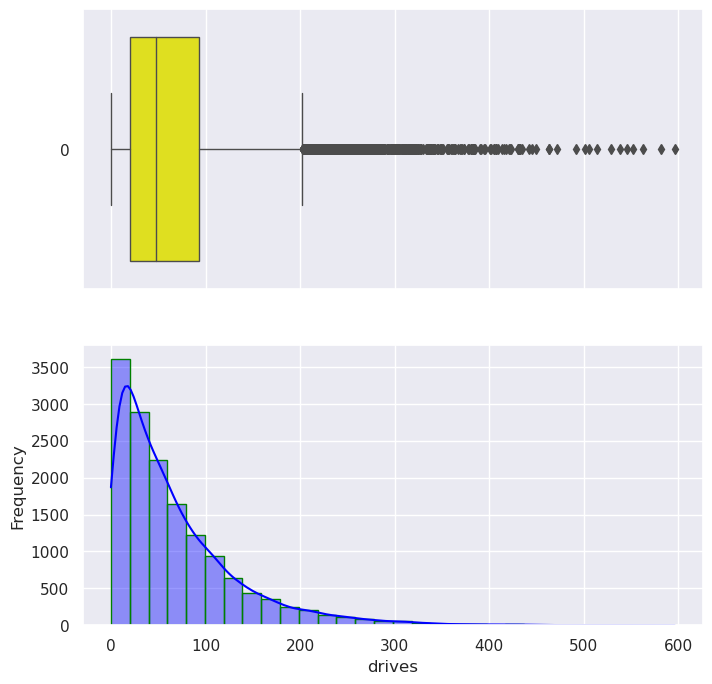

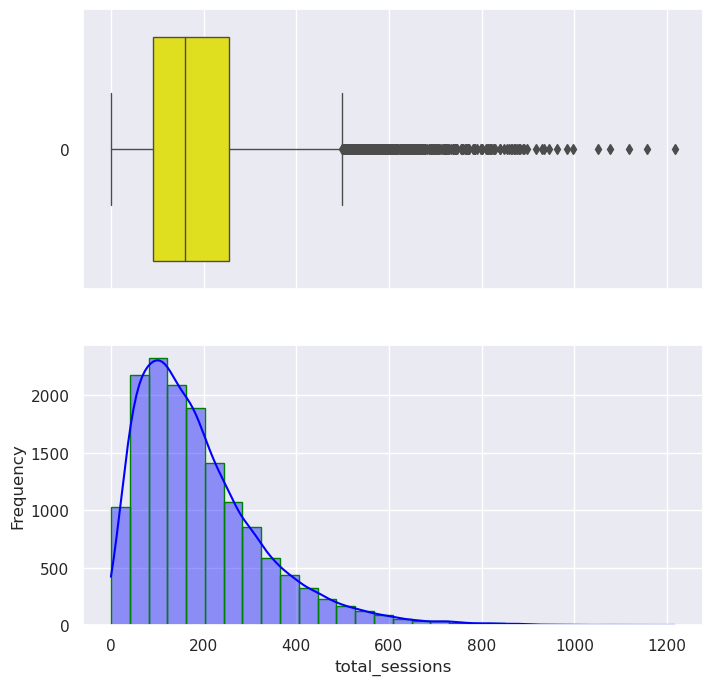

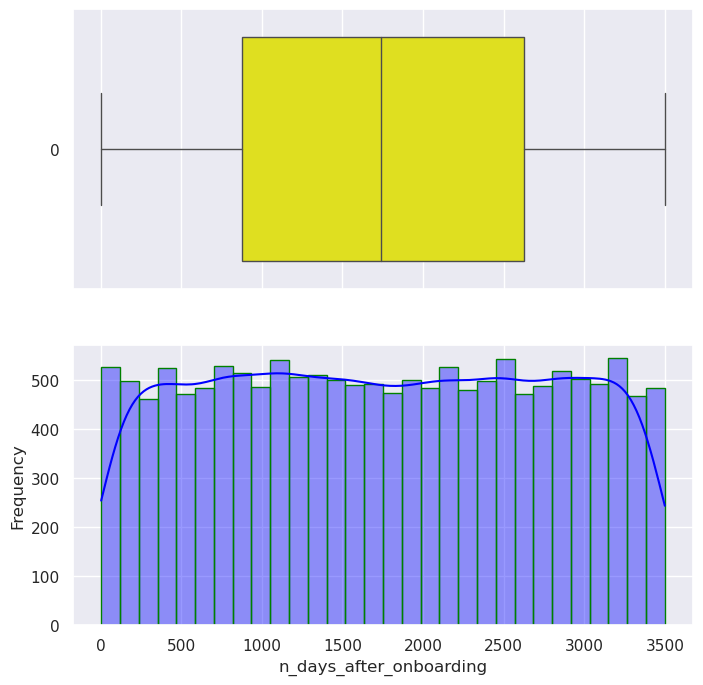

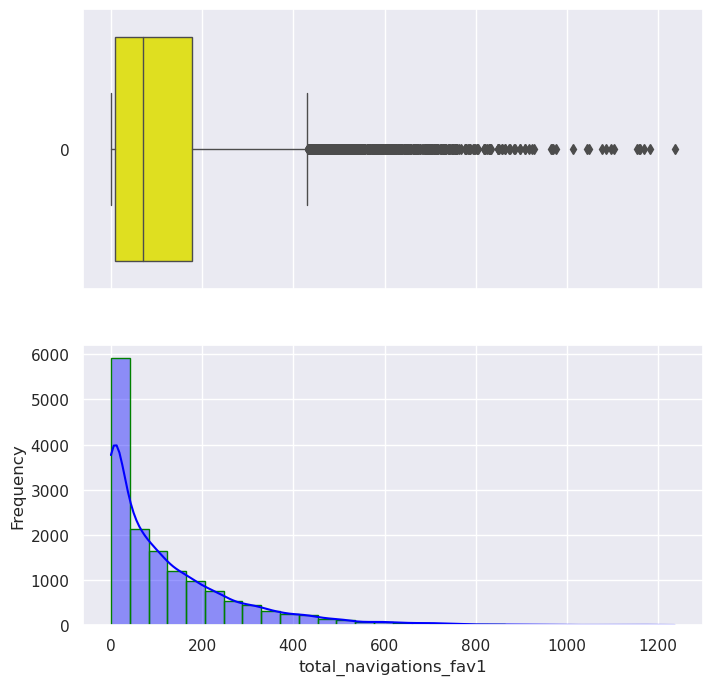

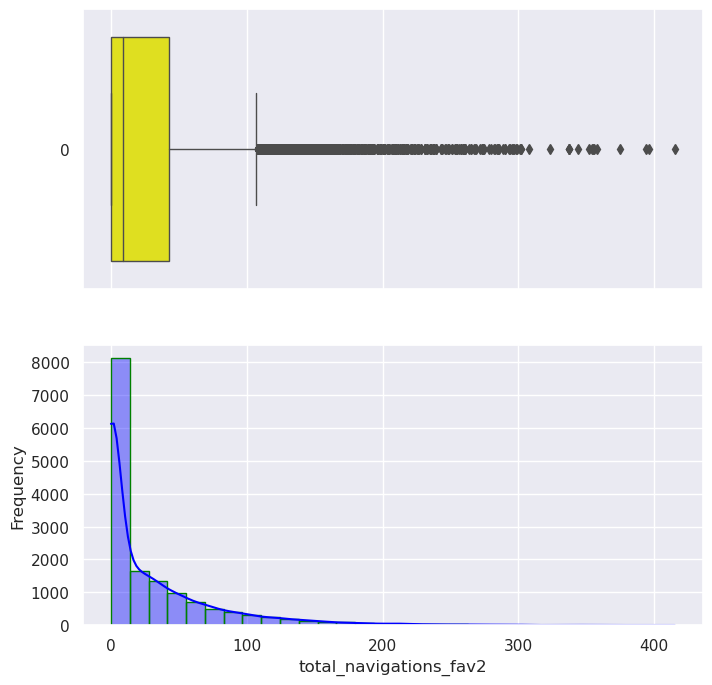

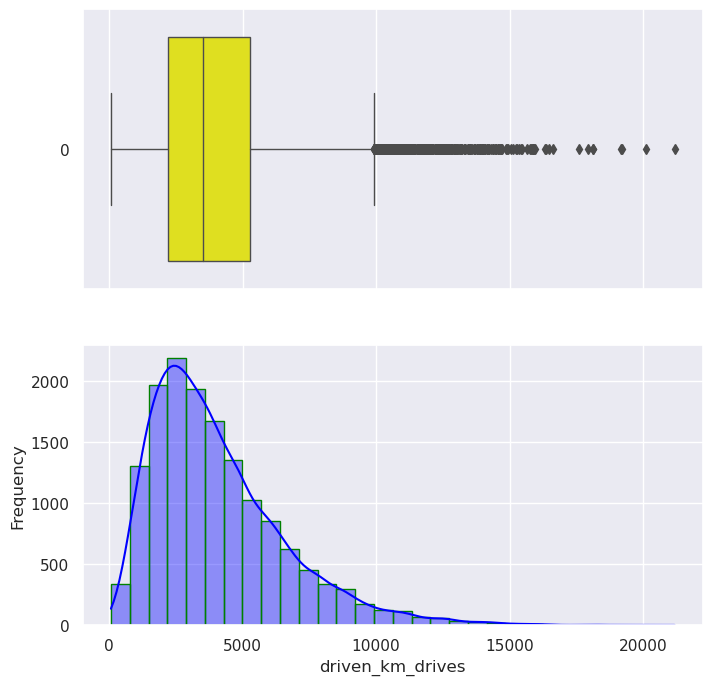

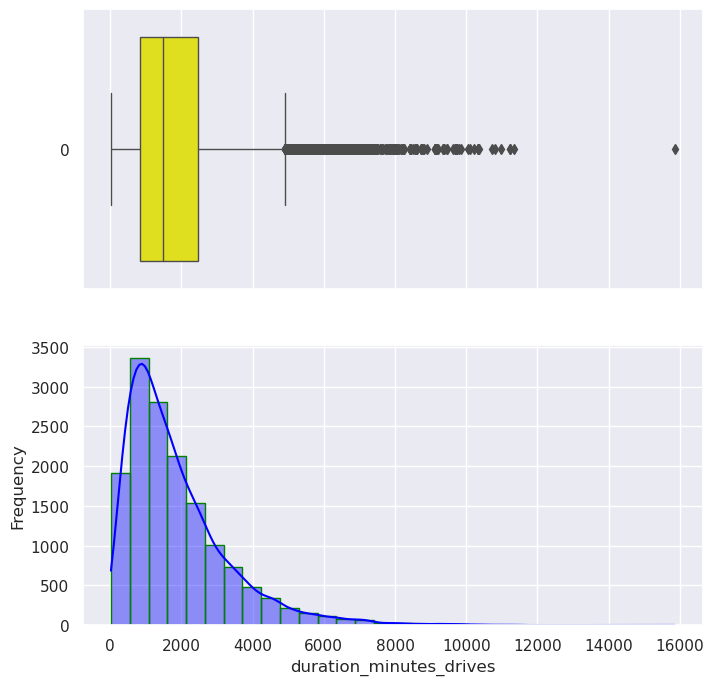

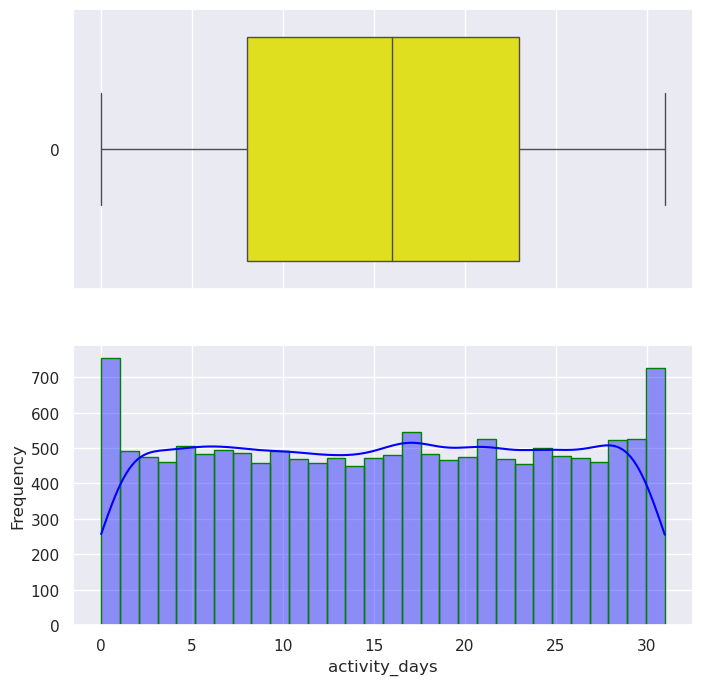

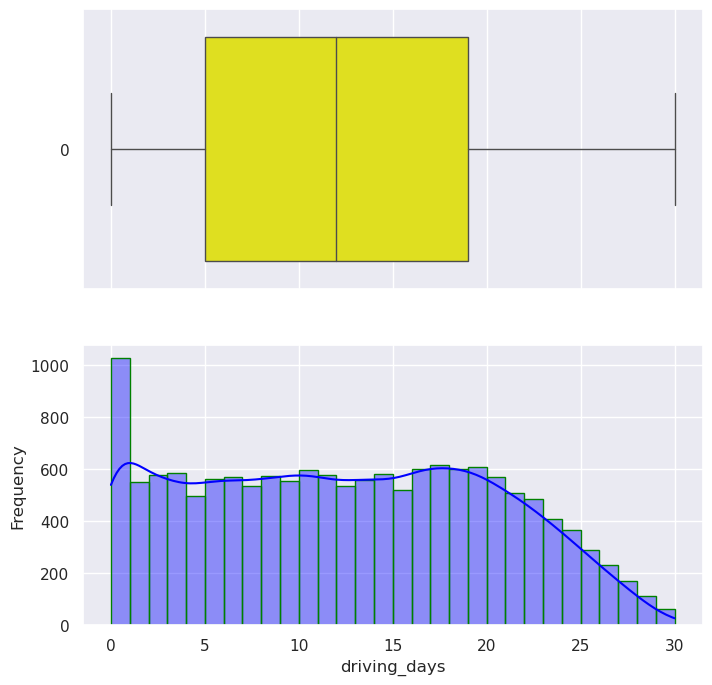

In [120]:
## Observing Distribution of the continious variables.

for i in df[nums]:
    sns.set(rc={"figure.figsize":(8, 8)});
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency');
    
    sns.boxplot(df[i], orient='h', ax=ax_box , linewidth= 1.0, color='yellow');
    sns.histplot(df[i], ax=ax_hist , bins = 30, kde=True, color='blue', edgecolor='green', alpha=0.4);

## Outliers keep/take

The initial observations have been made

In [121]:
## filtering the outliers.

not_transformation = ['n_days_after_onboarding', 'activity_days', 'driving_days']
to_transform = nums ^ not_transformation
to_transform

Index(['driven_km_drives', 'drives', 'duration_minutes_drives', 'sessions',
       'total_navigations_fav1', 'total_navigations_fav2', 'total_sessions'],
      dtype='object')

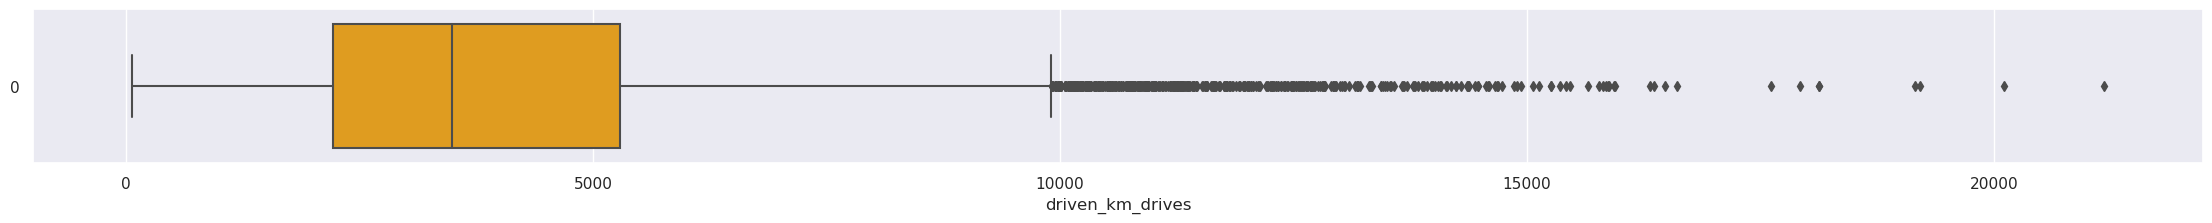

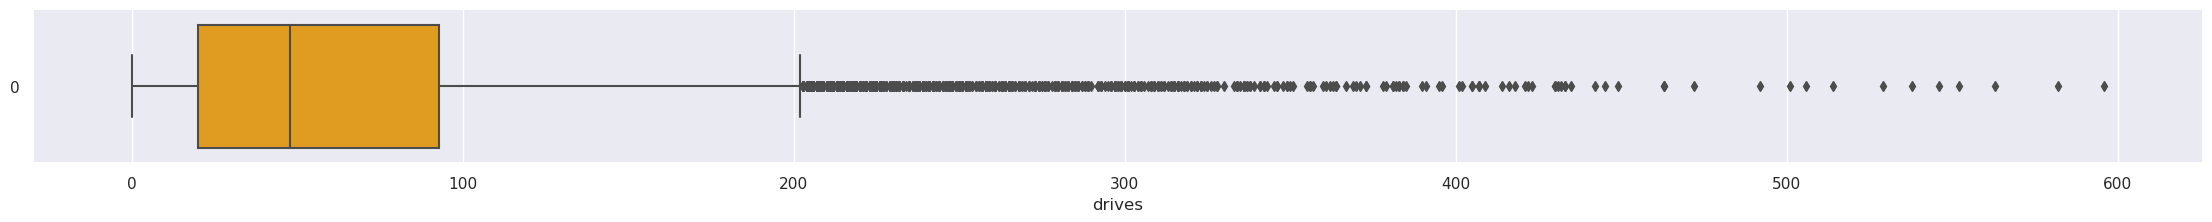

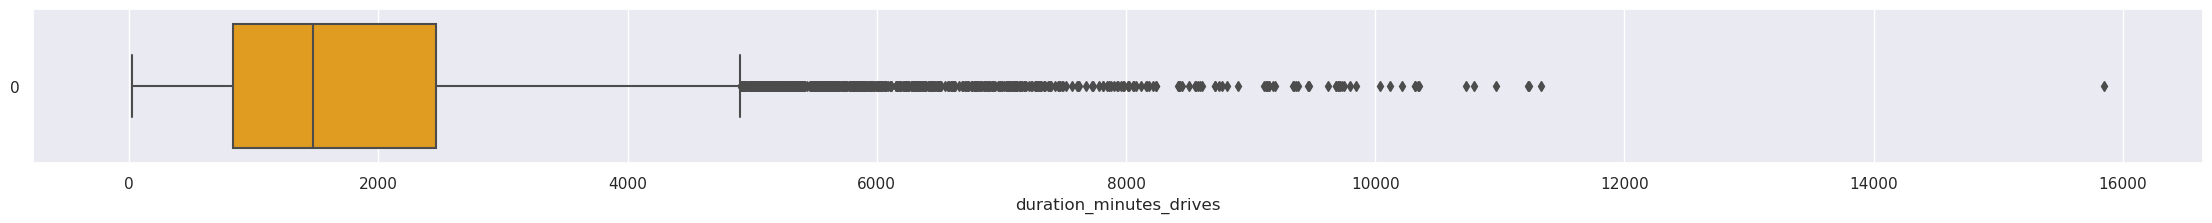

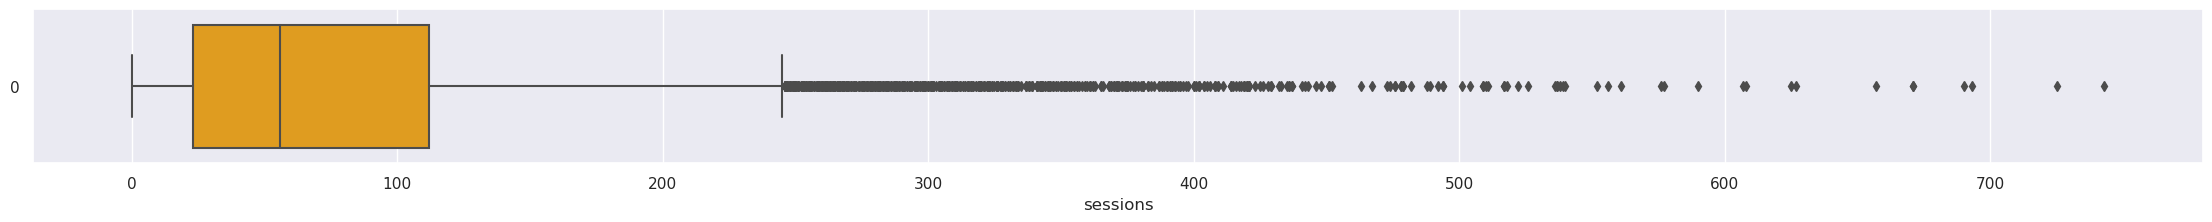

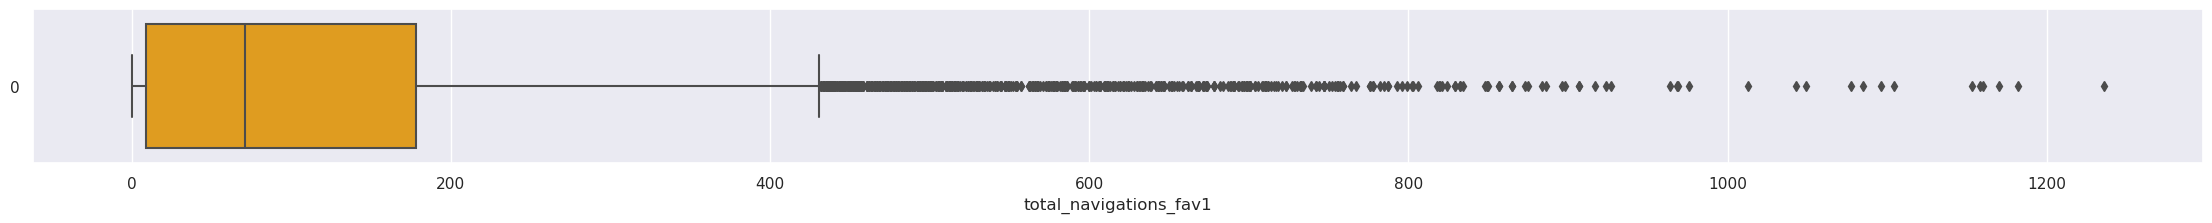

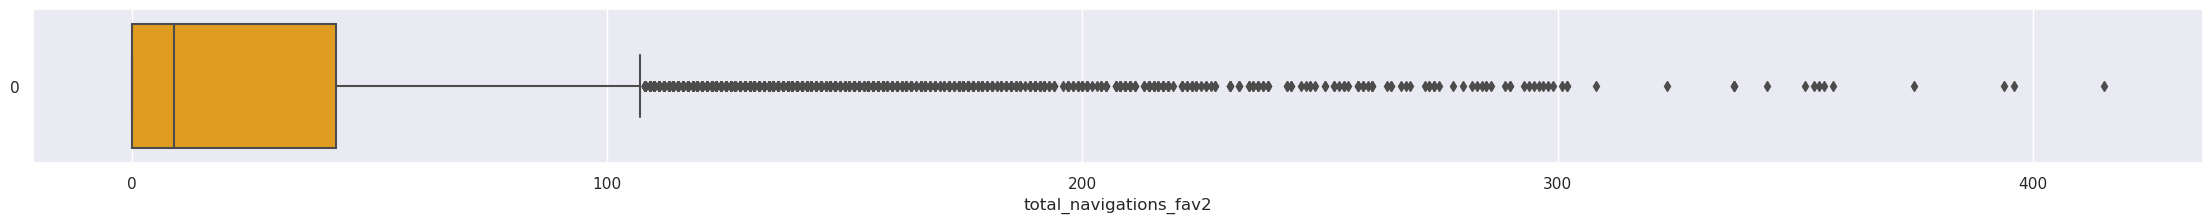

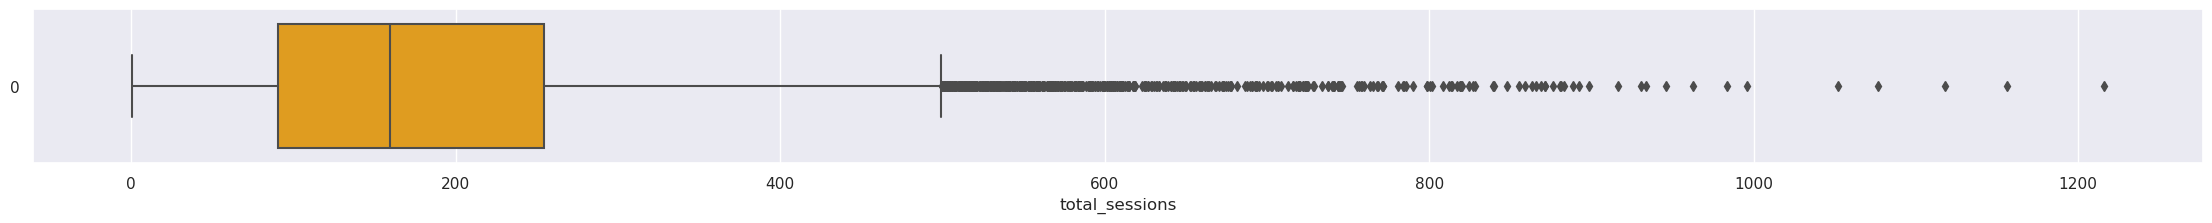

In [122]:
for i in to_transform:
    plt.figure(figsize = (28, 2))
    sns.boxplot(data=df[i], orient='h', color='orange');
    plt.xlabel(i)
    plt.show()

### Transformation of the continious variables

In [123]:
for j in to_transform:    
    df[j] =  winsorize(df[j], limits=(0.05, 0.05))

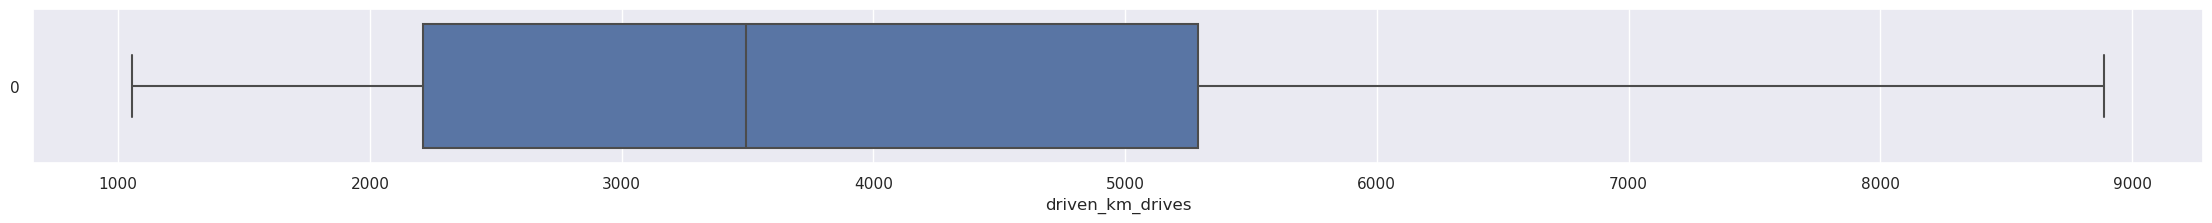

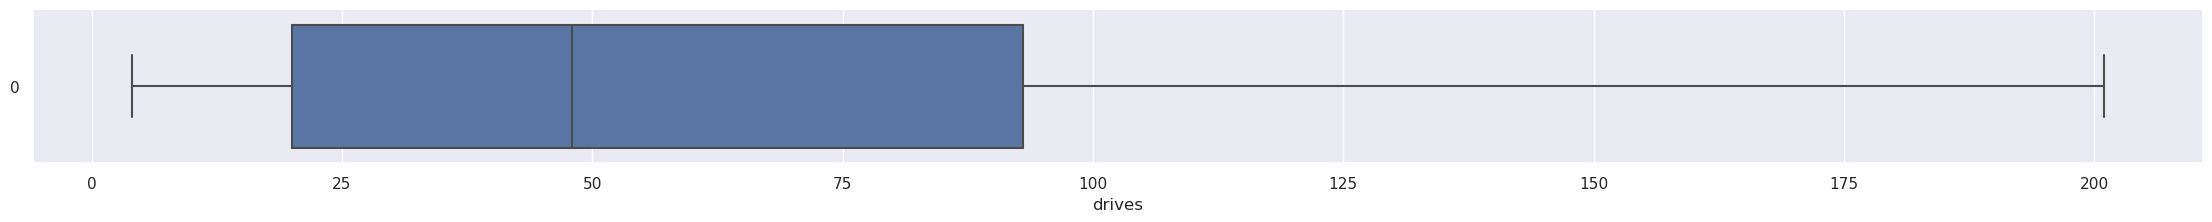

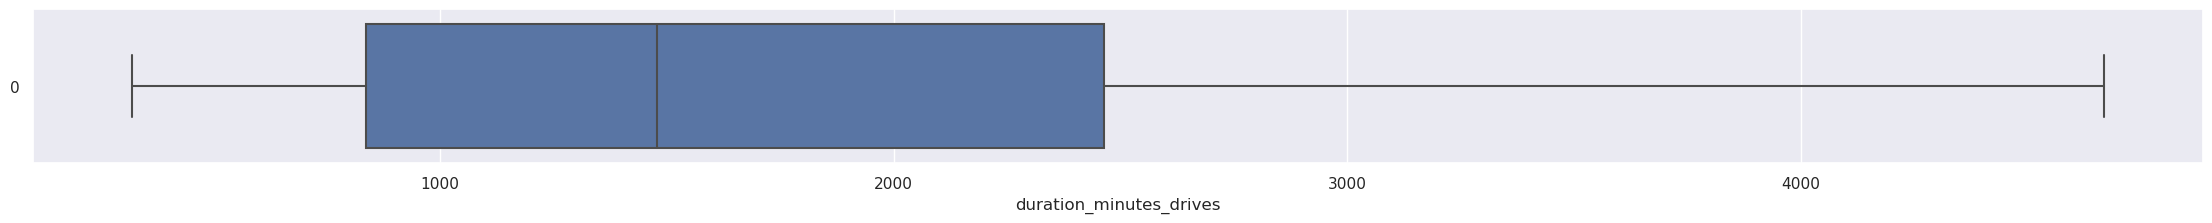

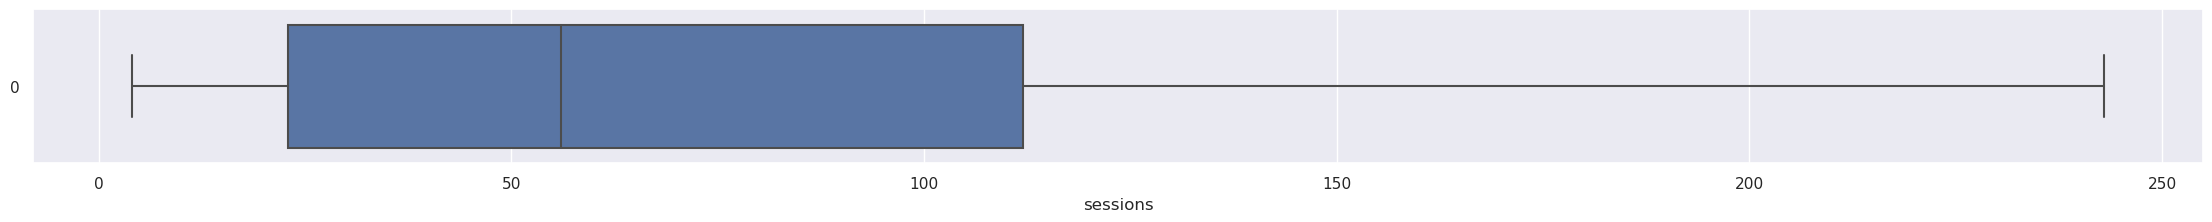

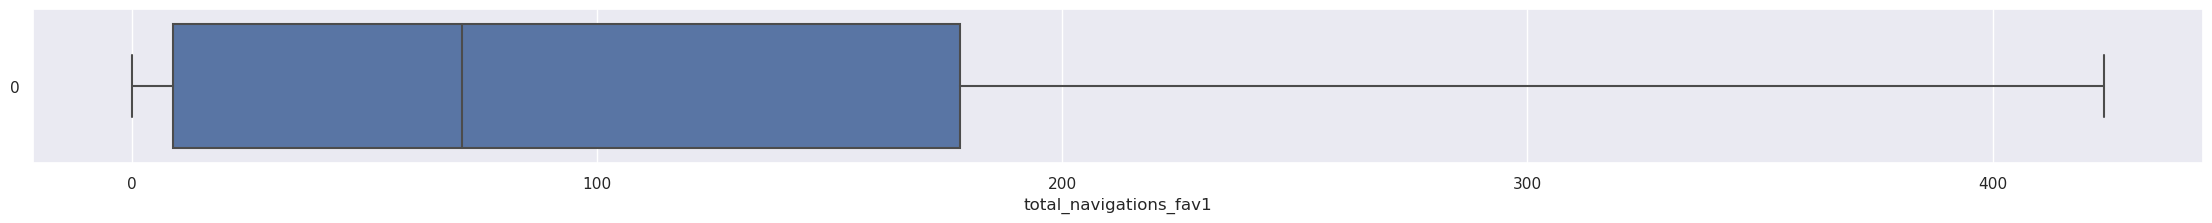

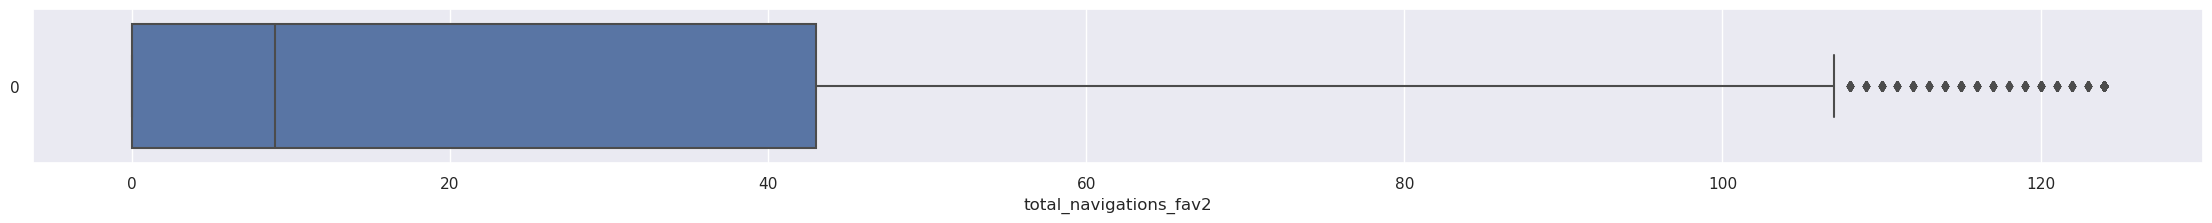

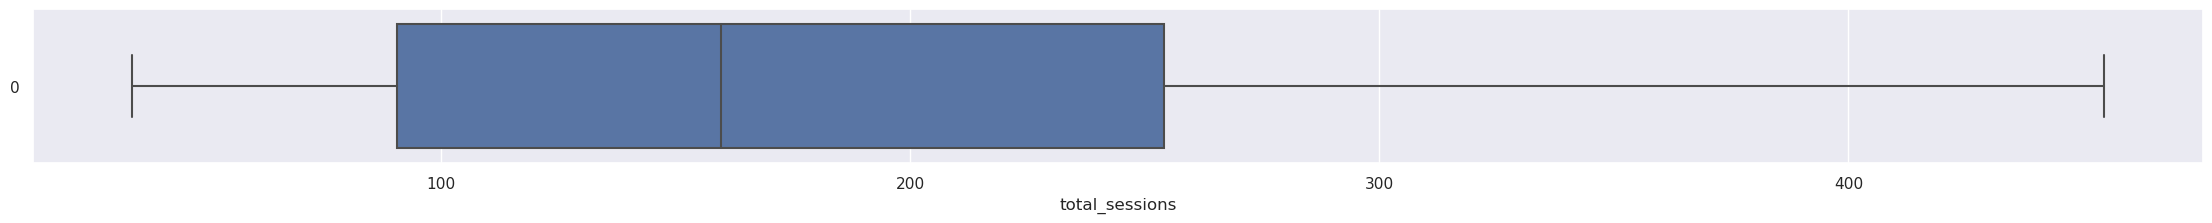

In [124]:
## check transformations

for i in to_transform:
    plt.figure(figsize = (28, 2))
    sns.boxplot(data=df[i], orient='h');
    plt.xlabel(i)
    plt.show()

In [164]:
from sklearn.utils import resample

def upsample_minority_class(data, feature):
    
    '''
    Upsamples the minority in a binary class in a DataFrame 
    to match the size of the majority class.

      Args:
        data: The DataFrame to be upsampled, pandas Data Frame.
        feature: the columns name, string.
        
      Returns:
        A DataFrame with the minority class upsampled.
    '''
    
    ## Identify data points from majority and minority classes
    
    clase_1 = data[feature].unique()[0]
    clase_2 = data[feature].unique()[1]
    
    primero = len(clase_1) 
    segundo = len(clase_2)
    
    majority_class = None

    if primero > segundo:
        majority_class = clase_1
        minority_class = clase_2
    else: 
        majority_class = clase_2
        minority_class = clase_1

    
    data_majority = data[data[feature] == majority_class]
    data_minority = data[data[feature] == clase_2]
    
    n_samples = len(data_majority)
                              
    data_minority_upsampled = resample(
          data_minority,
          replace=True,
          n_samples=n_samples,
          random_state=42)

    data_upsampled = pd.concat([data_majority, \
                                data_minority_upsampled]).reset_index(drop=True)

    return data_upsampled


In [165]:
df1 = upsample_minority_class(df, 'label')
df2 = upsample_minority_class(df1, 'device')

------- CLASS COUNTS --------------------

---------LABEL--------------------
retained    8339
churned     8267
Name: label, dtype: int64
8267, is: 49.7832% of the total
8339, is: 50.2168% of the total
This is the way, balance
------------------------------------------
count        16606
unique           2
top       retained
freq          8339
Name: label, dtype: object
------------------------------------------
---------DEVICE--------------------
Android    8303
iPhone     8303
Name: device, dtype: int64
8303, is: 50.0% of the total
8303, is: 50.0% of the total
This is the way, balance
------------------------------------------
count       16606
unique          2
top       Android
freq         8303
Name: device, dtype: object
------------------------------------------


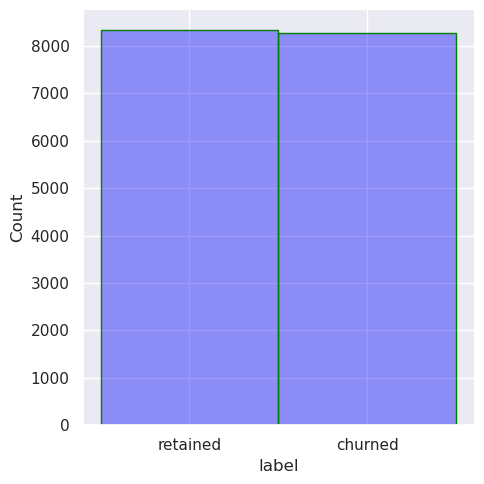

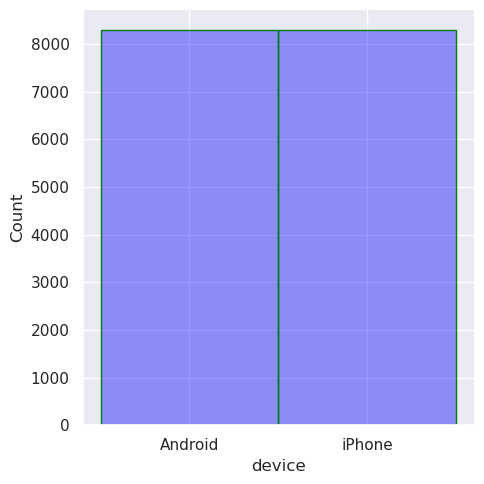

In [127]:
## Balance checking

def pct_checker(percentage, min_percentage, max_percentage):
    if percentage >= min_percentage and percentage <= max_percentage:
        return ('This is the way, balance')
    else:
        return ('not balance, unfortunately This is not the way')

print('------- CLASS COUNTS --------------------')
print()
for obj in cats:
    sns.displot(df2, x=obj, color='blue', edgecolor='green', alpha=0.4)
    print(f'---------{str.upper(obj)}--------------------')
    print(df2[obj].value_counts())
    
    a = df2[obj].value_counts()[0]
    b = df2[obj].value_counts()[1]
    pct_a = a / ( a + b ) * 100
    pct_b = b / ( a + b ) * 100
    
    print(f'{b}, is: {round(pct_b, 4)}% of the total')
    print(f'{a}, is: {round(pct_a, 4)}% of the total')
    
    ##
    ## As pct depend of each other we just need one check
    print(pct_checker(pct_a, 40, 60))
 
    print('------------------------------------------')
    print(df2[obj].describe())
    print('------------------------------------------')

In [128]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16606 entries, 0 to 16605
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    16606 non-null  object 
 1   sessions                 16606 non-null  int64  
 2   drives                   16606 non-null  int64  
 3   total_sessions           16606 non-null  float64
 4   n_days_after_onboarding  16606 non-null  int64  
 5   total_navigations_fav1   16606 non-null  int64  
 6   total_navigations_fav2   16606 non-null  int64  
 7   driven_km_drives         16606 non-null  float64
 8   duration_minutes_drives  16606 non-null  float64
 9   activity_days            16606 non-null  int64  
 10  driving_days             16606 non-null  int64  
 11  device                   16606 non-null  object 
dtypes: float64(3), int64(7), object(2)
memory usage: 1.5+ MB


In [129]:
## Now continious variables.

nums

Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'driving_days'],
      dtype='object')

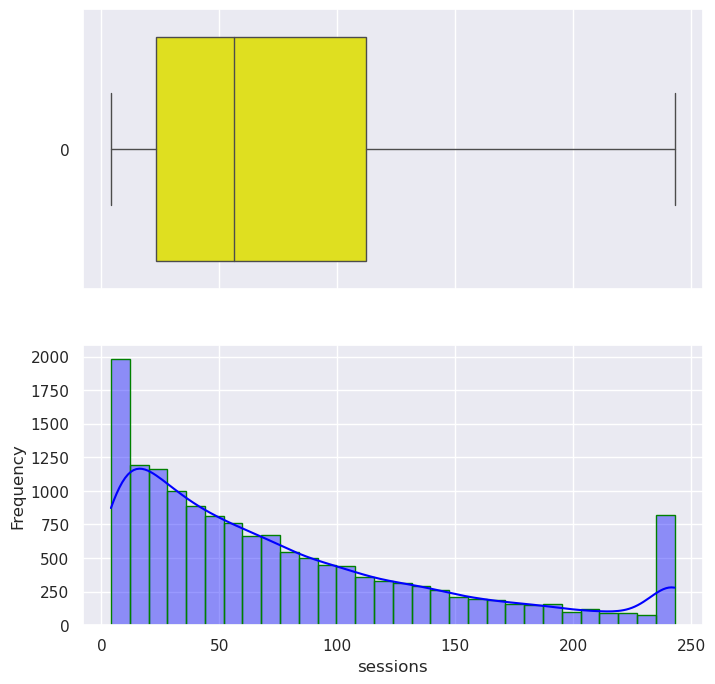

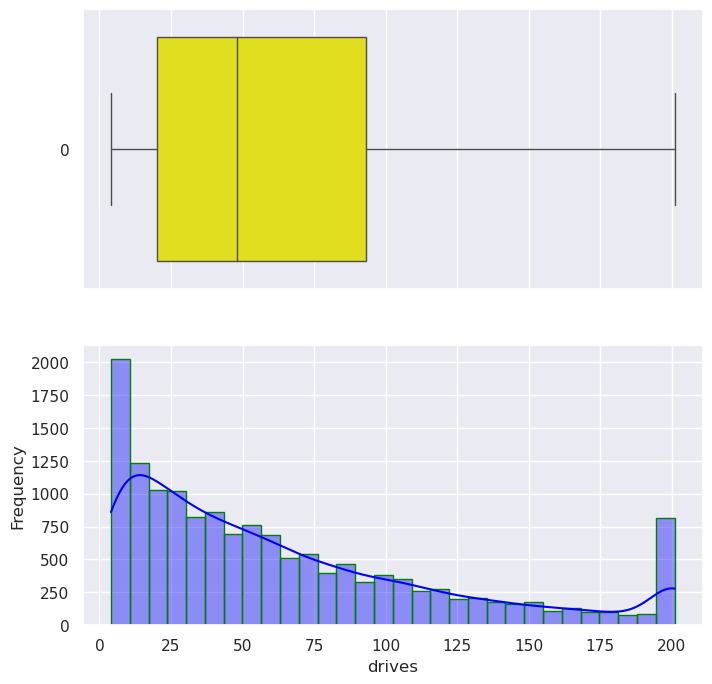

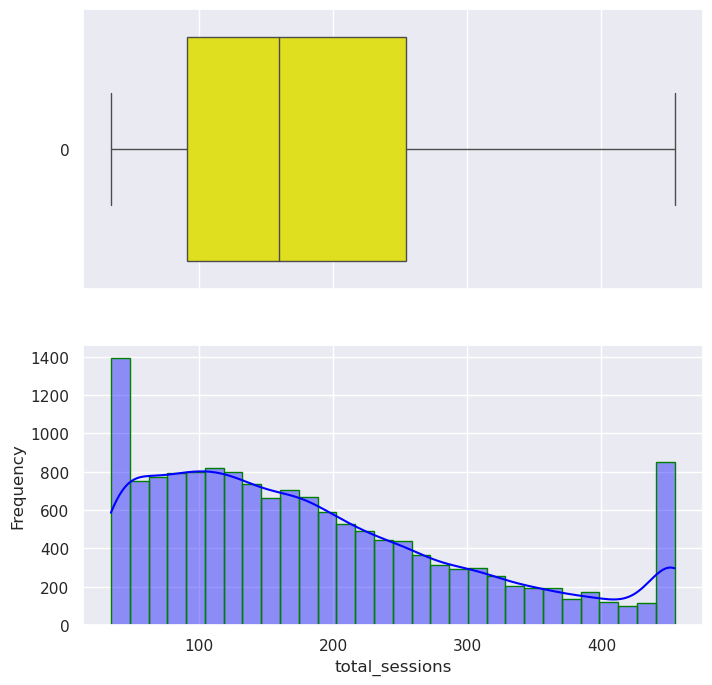

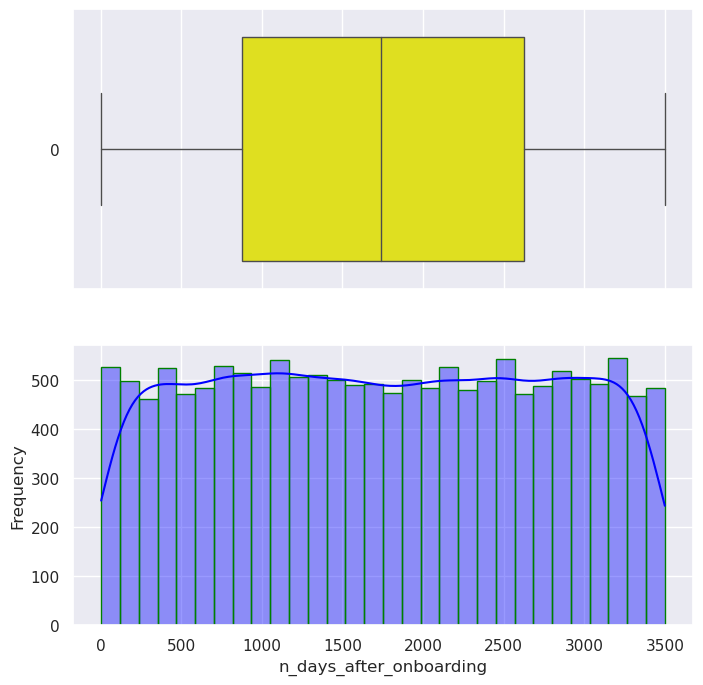

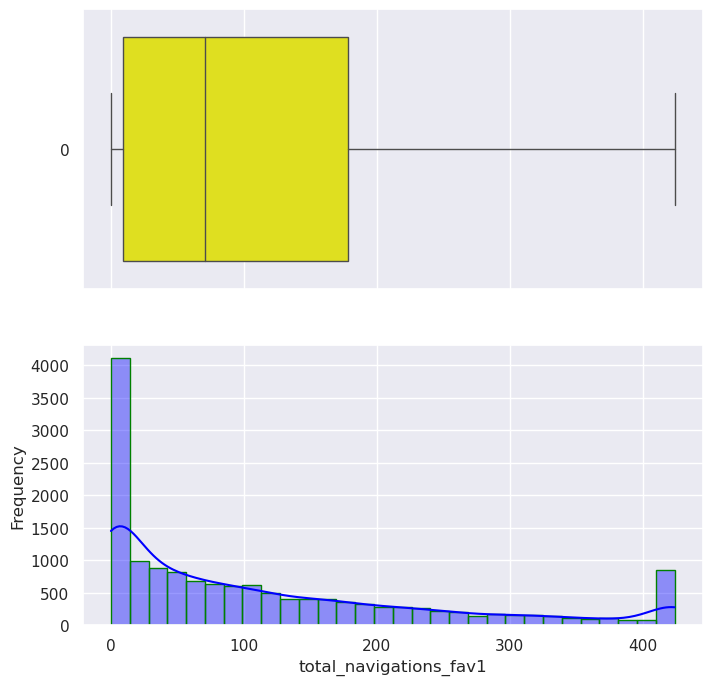

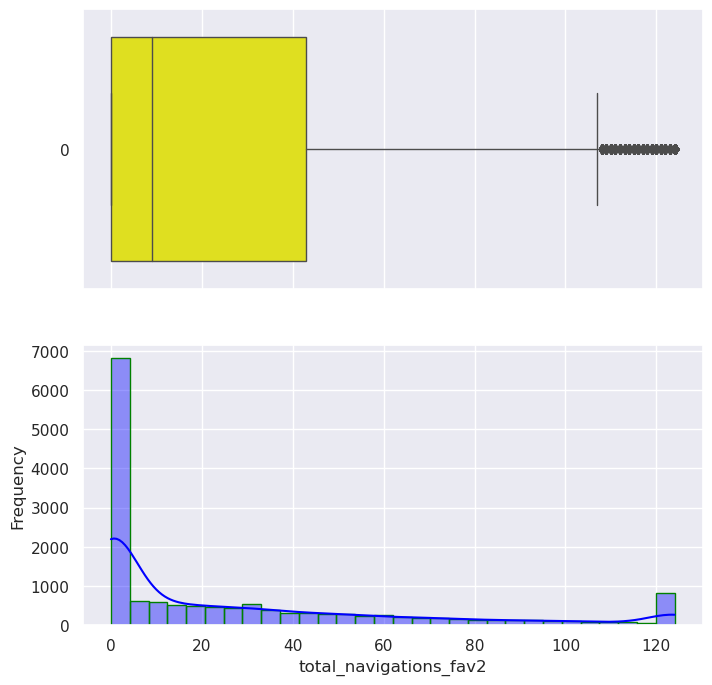

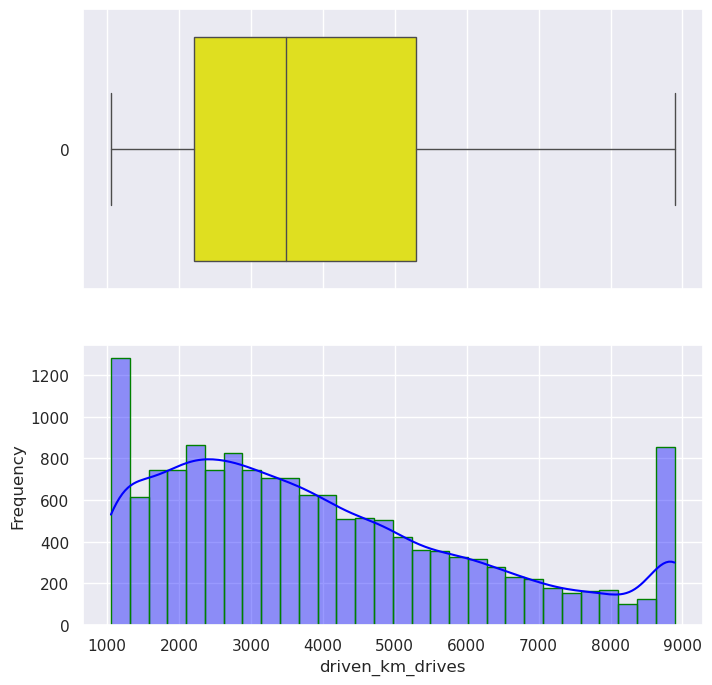

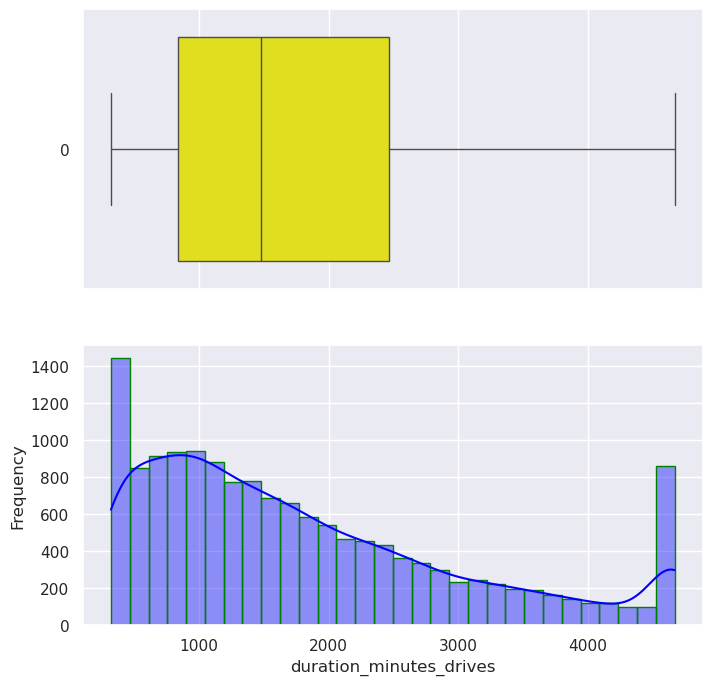

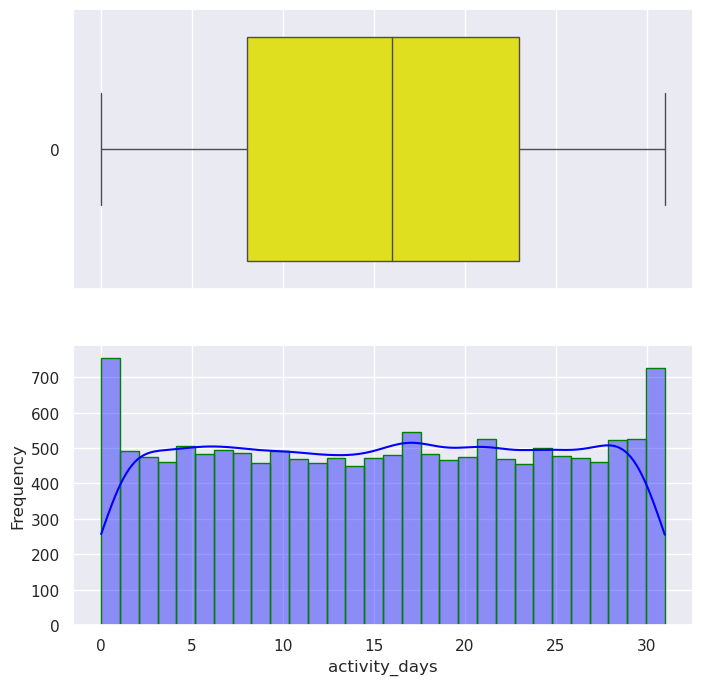

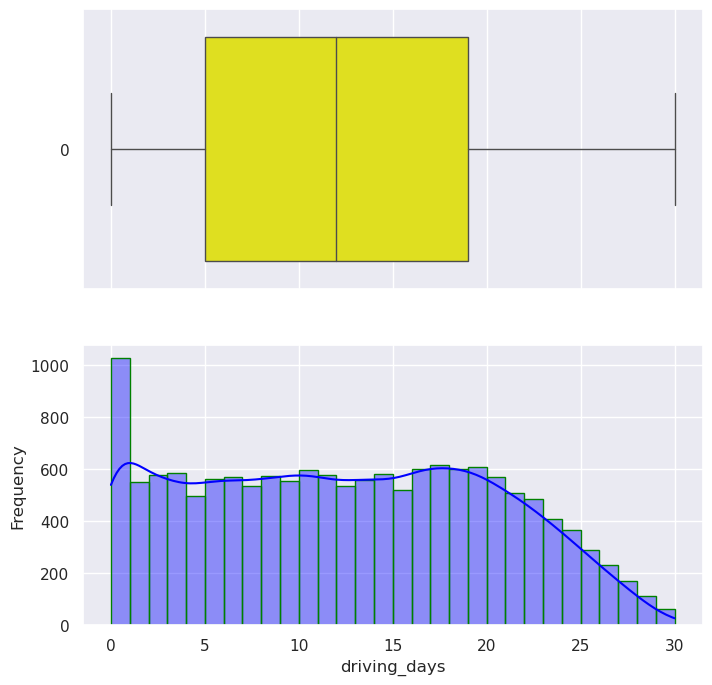

In [130]:
## Observing Distribution of the continious variables.

for i in df[nums]:
    sns.set(rc={"figure.figsize":(8, 8)});
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency');
    
    sns.boxplot(df[i], orient='h', ax=ax_box , linewidth= 1.0, color='yellow');
    sns.histplot(df[i], ax=ax_hist , bins = 30, kde=True, color='blue', edgecolor='green', alpha=0.4);

In [131]:
nums

Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'driving_days'],
      dtype='object')

## Notes

At first we can notice not normality.
We will notice that the log transformation of some features tend to fits better into normality that the not transformed.

This features seems to do not benefit that much.
- `'n_days_after_onboarding'`
- `'activity_days'`
- `'driving_days'`


In [132]:
## 
not_transformation = ['n_days_after_onboarding', 'activity_days', 'driving_days']
to_transform = nums ^ not_transformation
to_transform

Index(['driven_km_drives', 'drives', 'duration_minutes_drives', 'sessions',
       'total_navigations_fav1', 'total_navigations_fav2', 'total_sessions'],
      dtype='object')

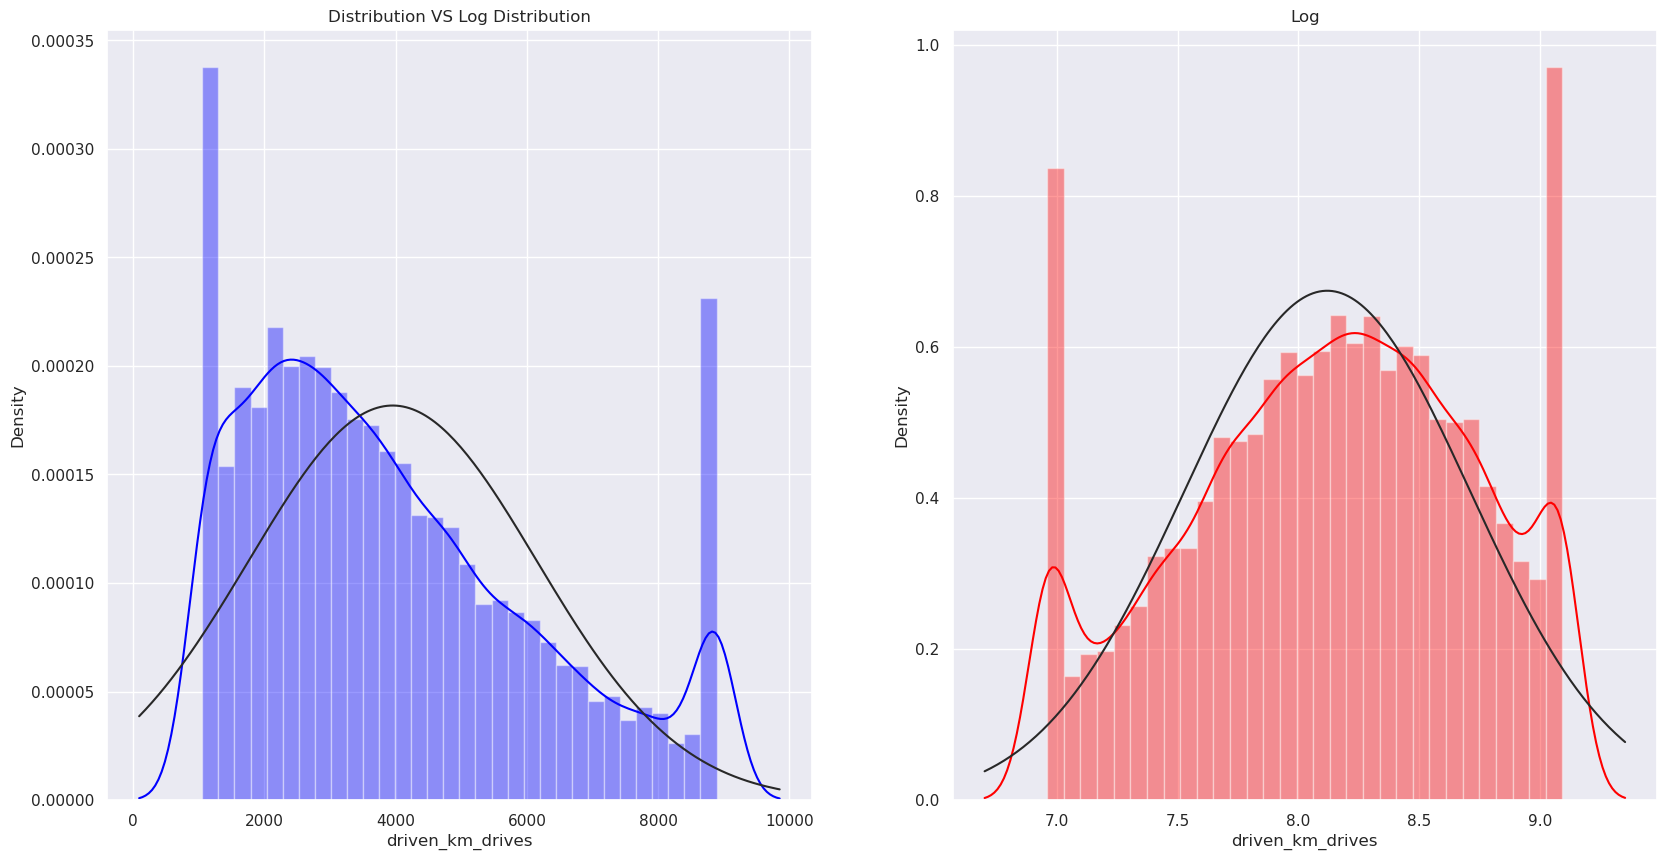

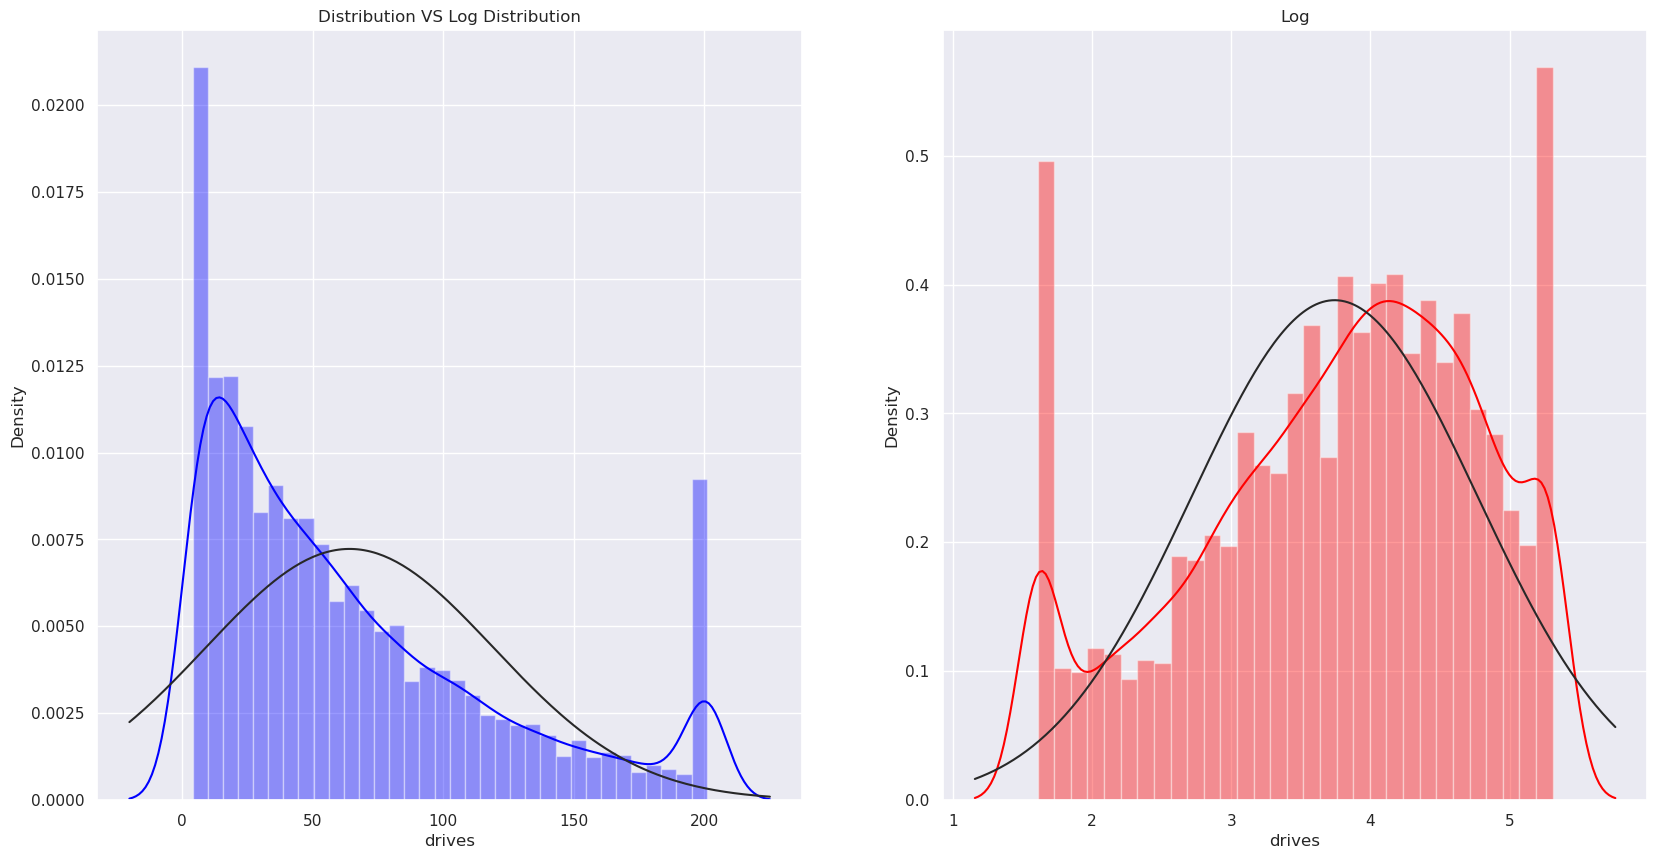

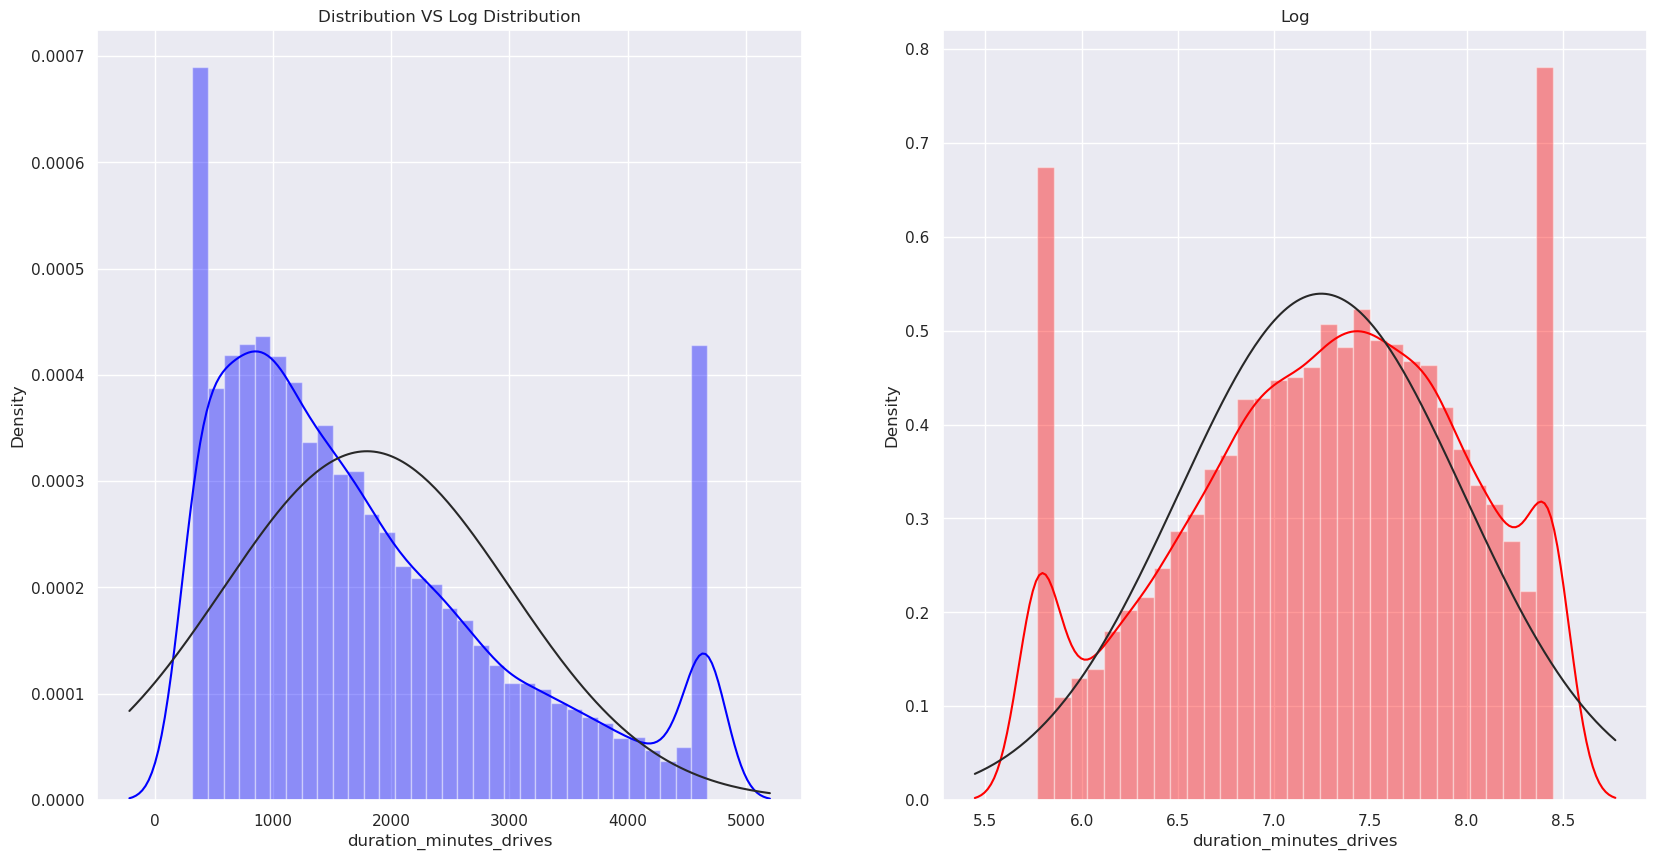

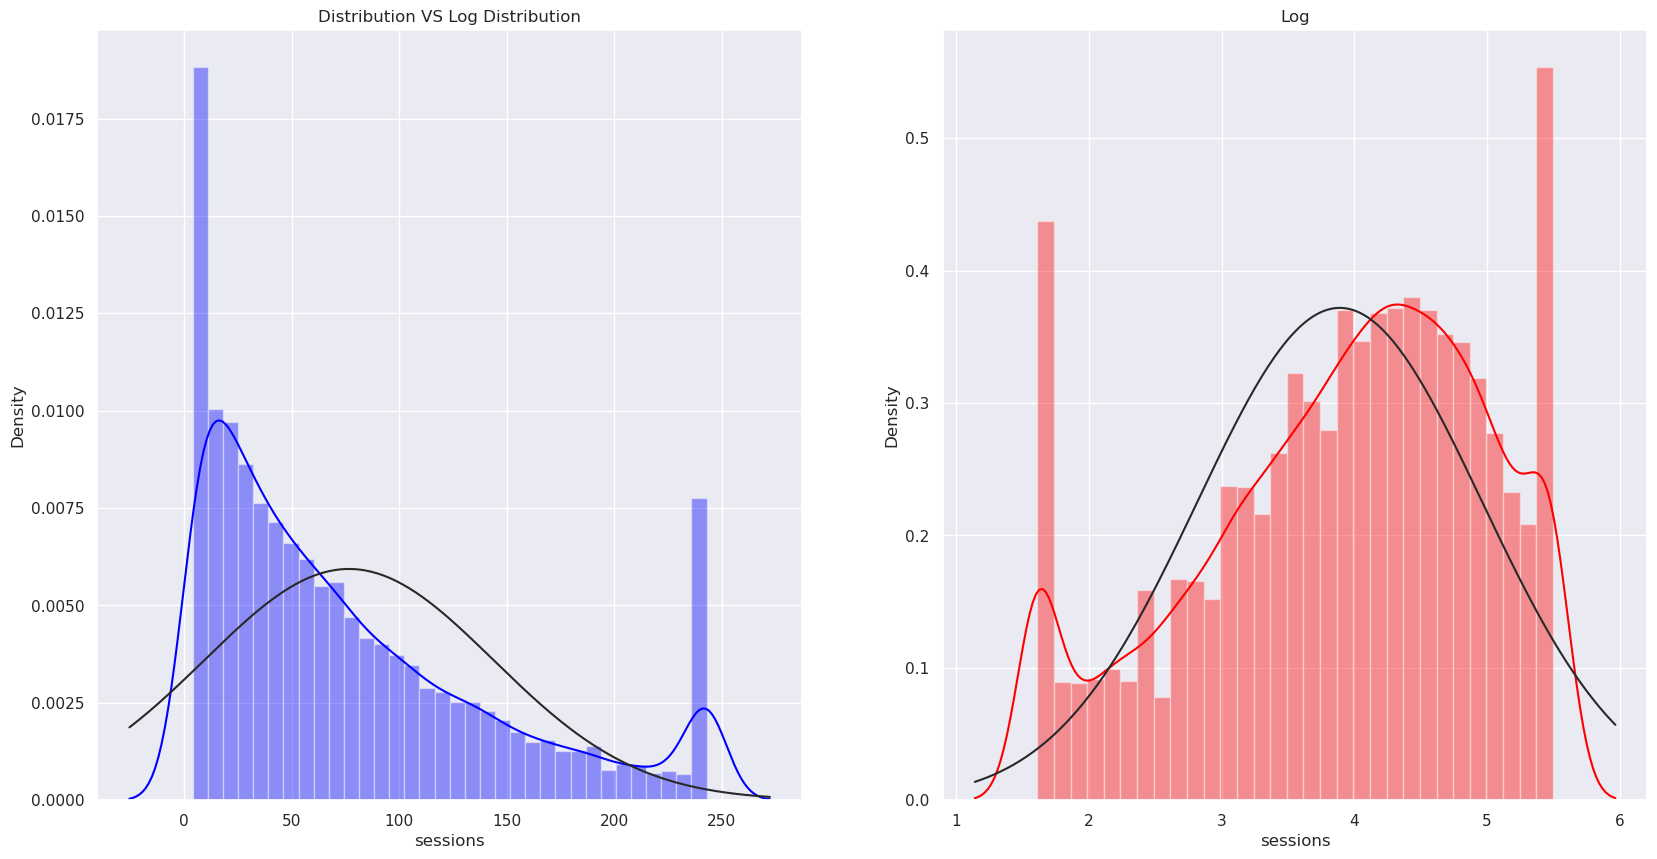

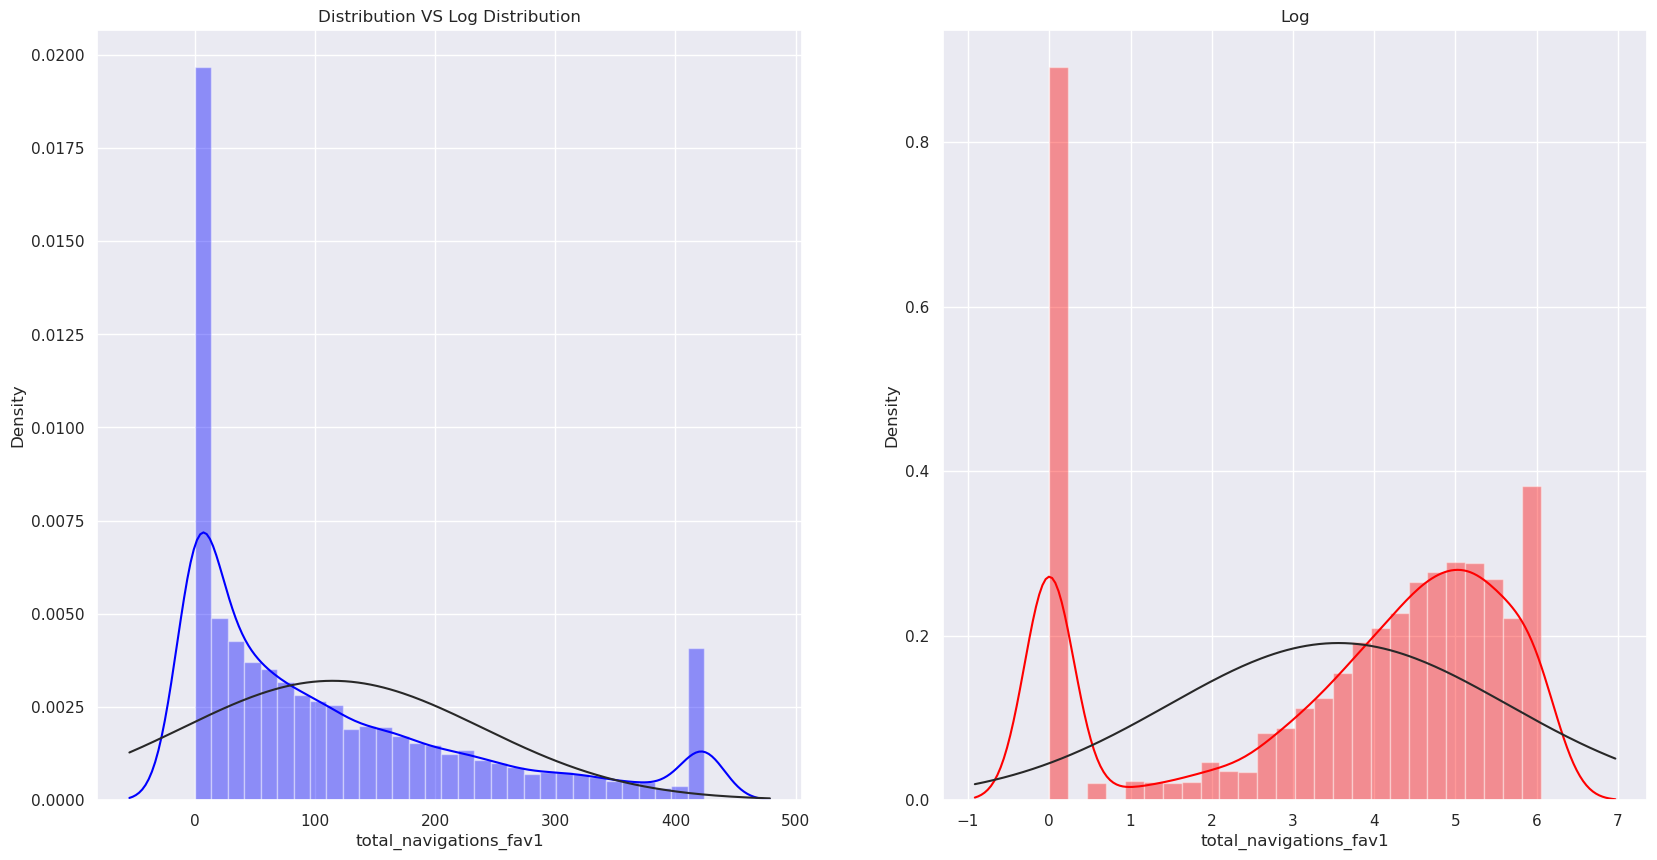

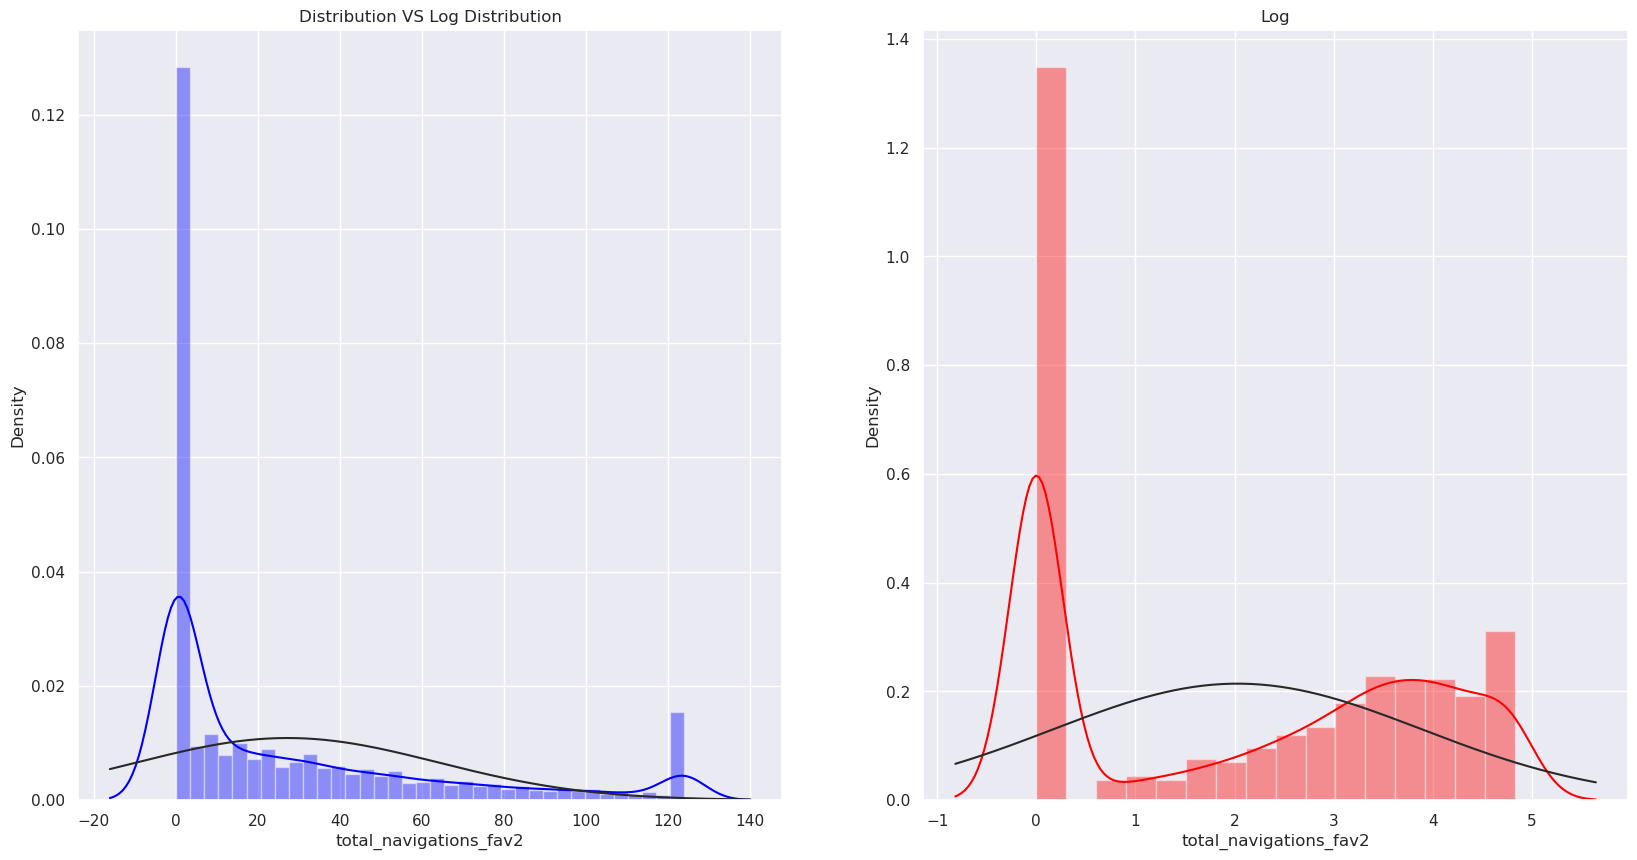

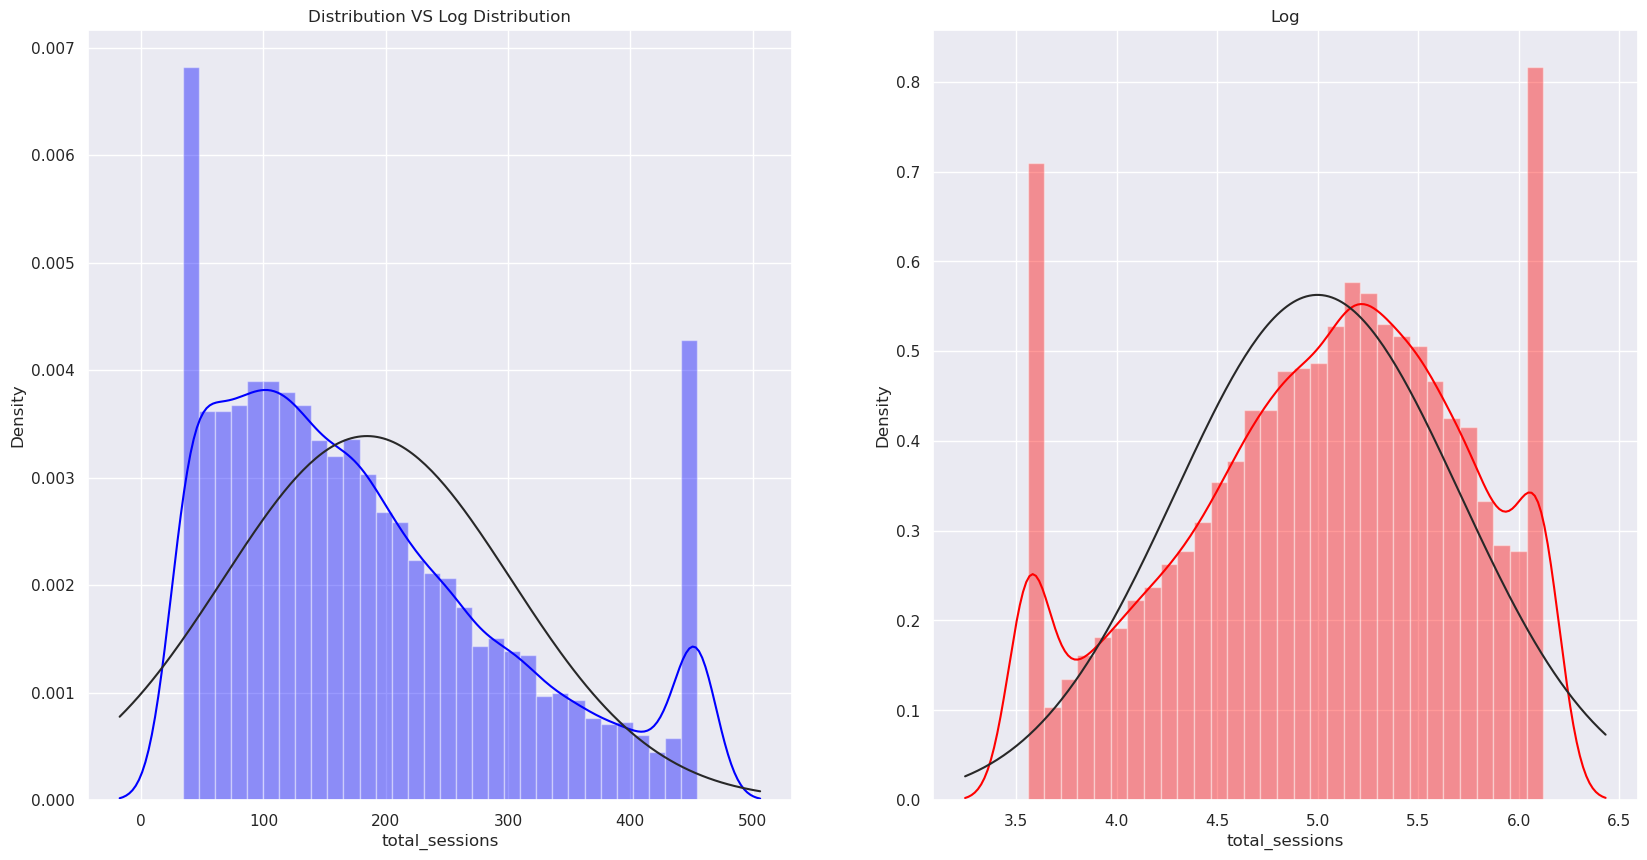

In [133]:
## Observing how a tranformation change distribution.
## 

for col in to_transform:
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.distplot(df[col], kde=True, fit=scipy.stats.norm , color='Blue') 
    plt.title('Distribution VS Log Distribution')
    plt.subplot(1, 2, 2)
    sns.distplot(np.log1p(df[col]), kde=True, fit=scipy.stats.norm, color='Red') ## fits is deprecated, still good to demo.
    plt.title('Log');

## Note:
np.log(0) = -inf
instead of using the log we will use the `np.log1p()`
The `np.log1p()` function in NumPy returns the natural logarithm of one plus the input array, element-wise. It calculates `log(1 + x)`.

In [134]:
np.log(0), np.log(0.000001)

(-inf, -13.815510557964274)

In [135]:
np.log1p(0), np.log(0.000001)

(0.0, -13.815510557964274)

In [136]:
for col in to_transform:
    df[col] = np.log1p(df[col])

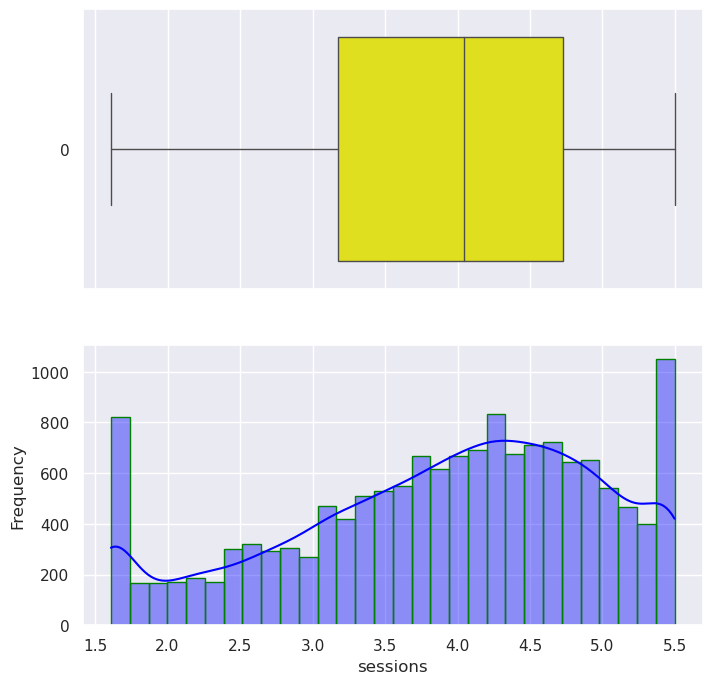

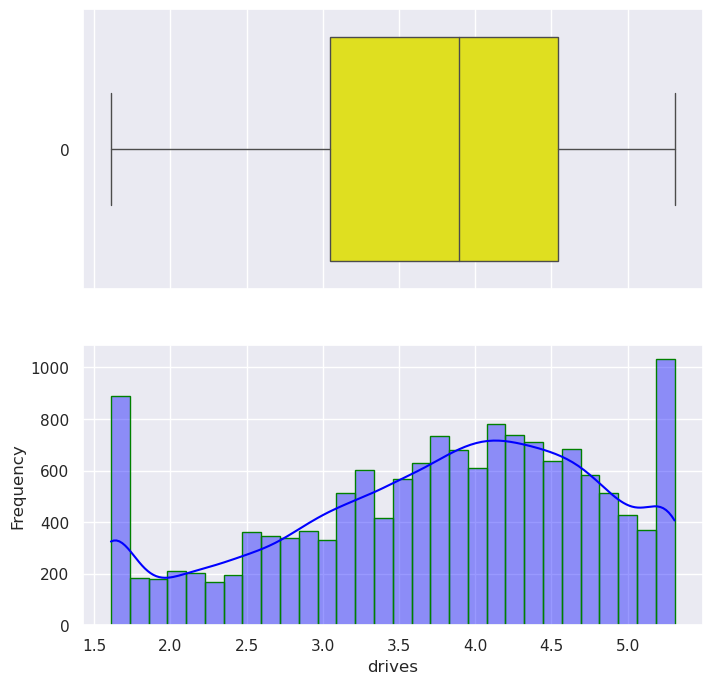

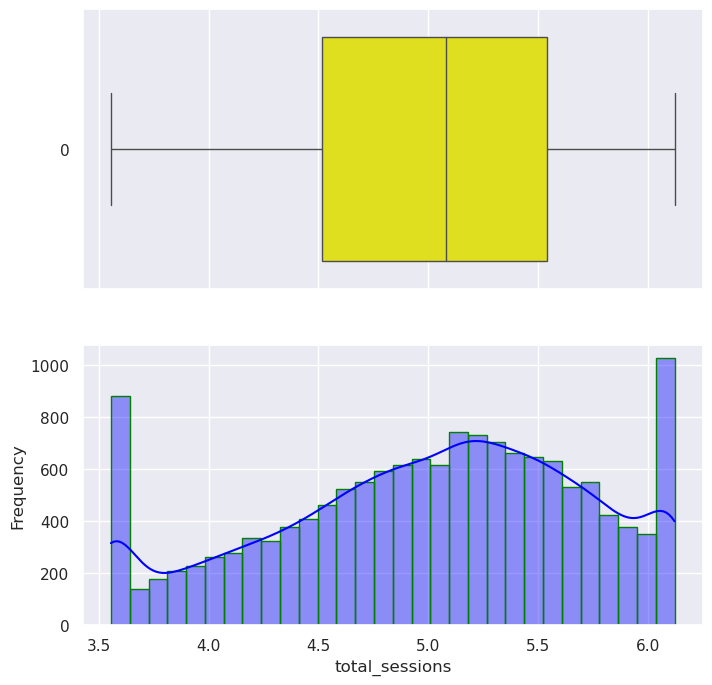

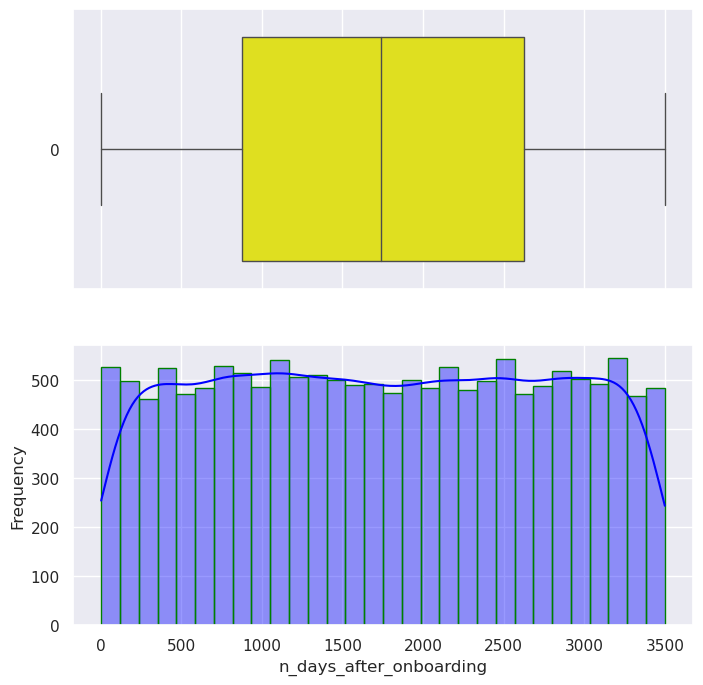

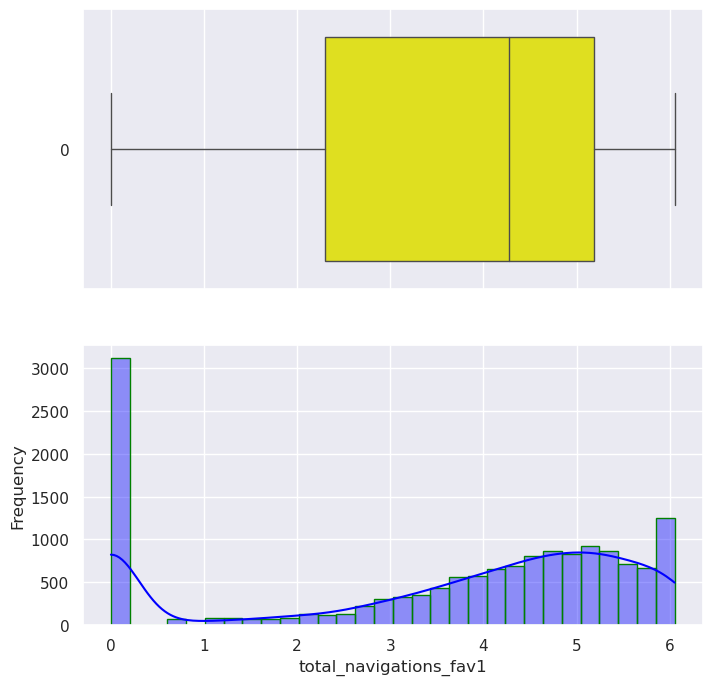

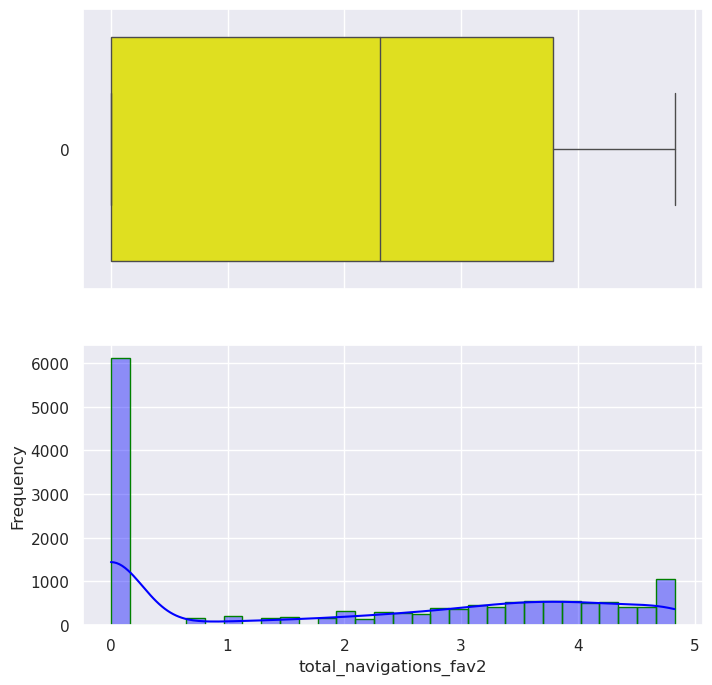

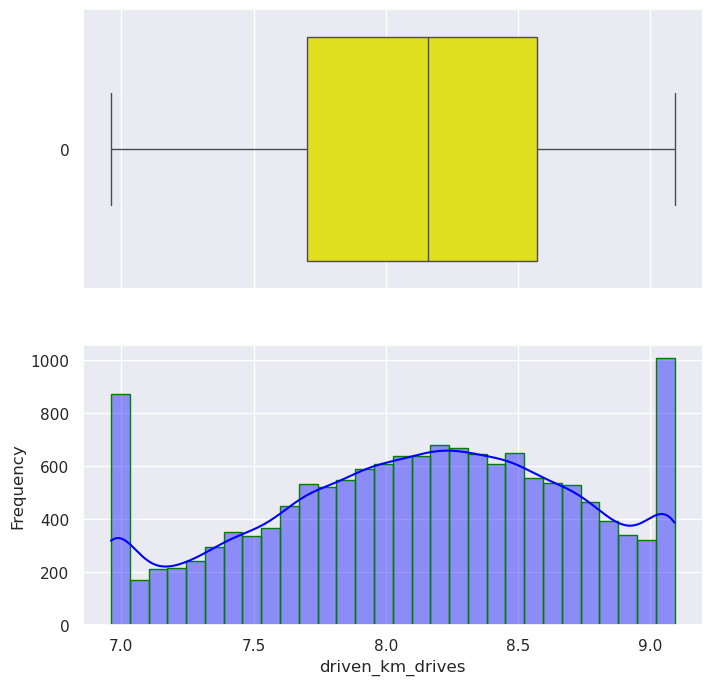

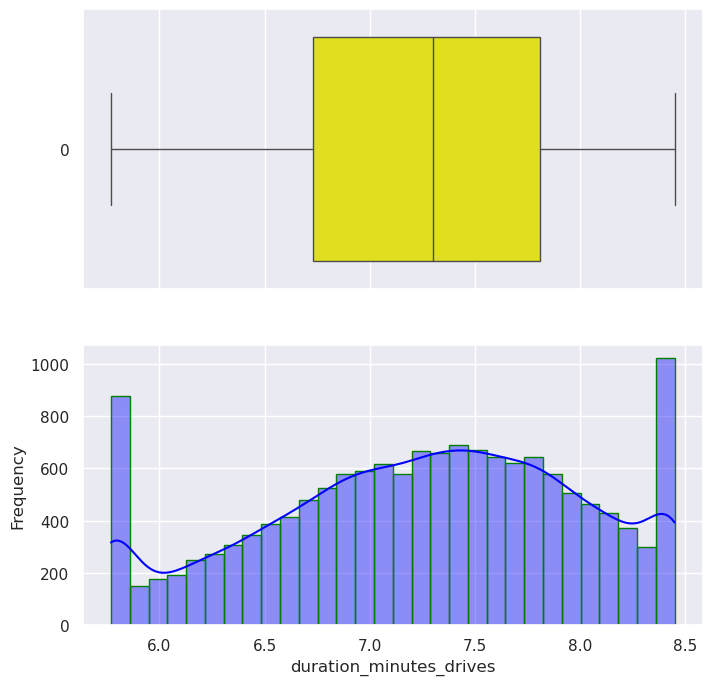

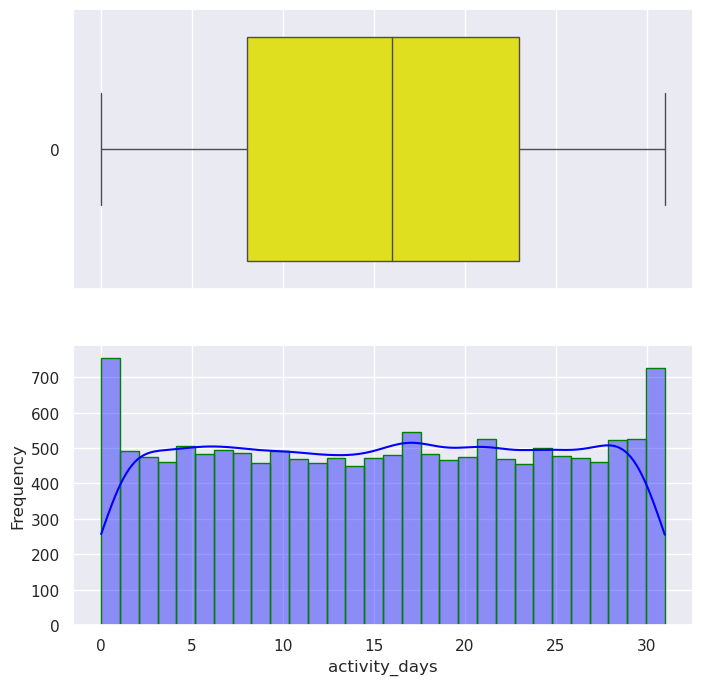

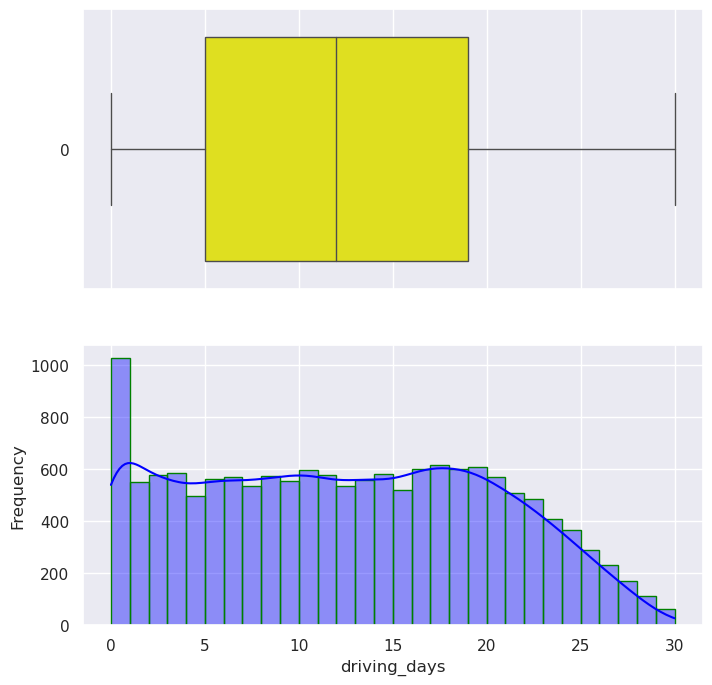

In [137]:
## Observing Distribution of the continious variables transformed.

for i in df[nums]:
    sns.set(rc={"figure.figsize":(8, 8)});
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency');
    
    sns.boxplot(df[i], orient='h', ax=ax_box , linewidth= 1.0, color='yellow');
    sns.histplot(df[i], ax=ax_hist , bins = 30, kde=True, color='blue', edgecolor='green', alpha=0.4);

In [138]:
ff = nums ^ ['n_days_after_onboarding'] ## on boarding scale is huge so we can not see the rest
## I will scale the data centered at zero soon.

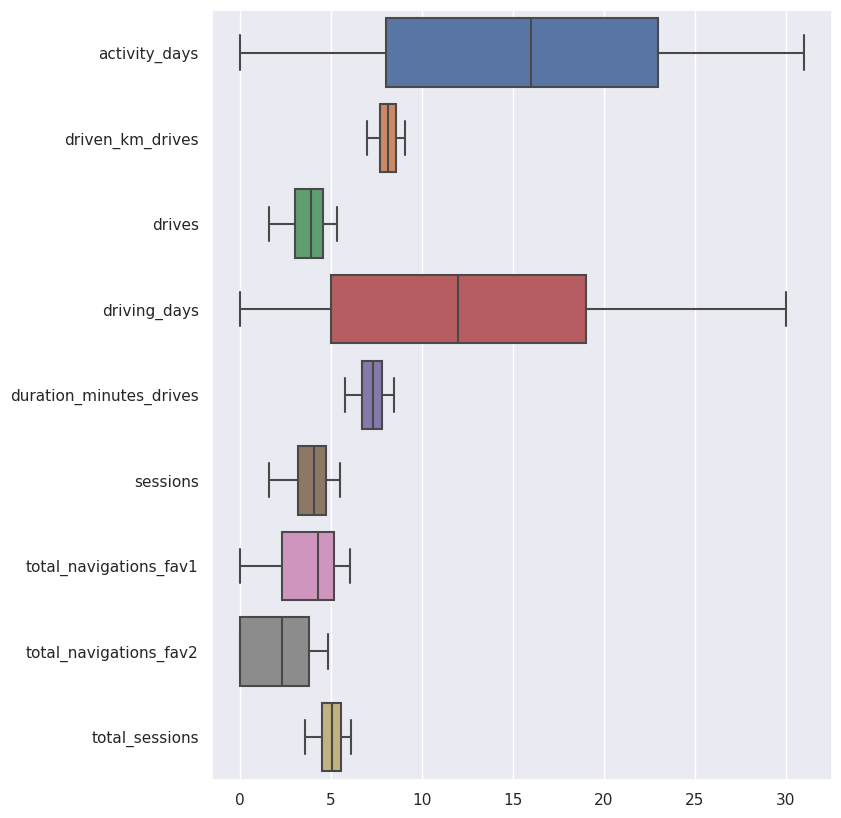

In [139]:
## Box plots
plt.figure(figsize = (8,10))
sns.boxplot(data=df[ff], orient='h', showfliers=False );

In [140]:
nums

Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'driving_days'],
      dtype='object')

In [141]:
cats

Index(['label', 'device'], dtype='object')

In [142]:
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,retained,5.497168,5.308268,5.696248,2276,5.342334,0.000000,7.874680,7.594268,28,19,Android
1,retained,4.897840,4.682131,5.792698,1225,2.995732,4.174387,9.092790,8.058793,13,11,iPhone
2,retained,4.744932,4.564348,4.916493,2651,0.000000,0.000000,8.026219,7.385067,14,8,Android
3,retained,3.912023,3.713572,4.228135,15,5.777652,2.079442,6.960478,6.377061,7,3,iPhone
4,retained,4.442651,4.234107,5.131359,1562,5.117994,1.791759,8.281775,7.107062,27,18,Android


## missing values

Also, the categorical variables transformation to binary classes, both.

In [143]:
eda.miss_df(df2)

,Total,Percent
label,0,0.0
sessions,0,0.0
drives,0,0.0
total_sessions,0,0.0
n_days_after_onboarding,0,0.0
total_navigations_fav1,0,0.0
total_navigations_fav2,0,0.0
driven_km_drives,0,0.0
duration_minutes_drives,0,0.0
activity_days,0,0.0


In [144]:
## encoding cat values.
## Also making a copy of the data.
df1 = df.copy()

In [145]:
df1.head(2)

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,retained,5.497168,5.308268,5.696248,2276,5.342334,0.000000,7.87468,7.594268,28,19,Android
1,retained,4.897840,4.682131,5.792698,1225,2.995732,4.174387,9.09279,8.058793,13,11,iPhone


In [146]:
## Transformation into a binary class
df2.loc[df2['label'] == 'churned', 'label'] = 0
df2.loc[df2['label'] == 'retained', 'label'] = 1
df2.loc[df2['device'] == 'iPhone', 'device'] = 0
df2.loc[df2['device'] == 'Android', 'device'] = 1

In [147]:
df2.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,1,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,1
1,1,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,1
2,1,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,1
3,1,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,1
4,1,80,64,132.830506,3154,39,16,8531.248070,4669.675626,1,0,1


In [148]:
eda.miss_df(df2)

,Total,Percent
label,0,0.0
sessions,0,0.0
drives,0,0.0
total_sessions,0,0.0
n_days_after_onboarding,0,0.0
total_navigations_fav1,0,0.0
total_navigations_fav2,0,0.0
driven_km_drives,0,0.0
duration_minutes_drives,0,0.0
activity_days,0,0.0


In [149]:
eda.get_invalid_values(df2)

,column,nulls,invalids,unique_item
label,label,0,0,"[1, 0]"
sessions,sessions,0,0,"[243, 114, 84, 57, 80, 30, 48, 4, 132, 75, 16,..."
drives,drives,0,0,"[201, 95, 68, 46, 64, 25, 38, 4, 106, 60, 14, ..."
total_sessions,total_sessions,0,0,"[296.7482729, 135.5229263, 168.2470201, 183.53..."
n_days_after_onboarding,n_days_after_onboarding,0,0,"[2276, 2651, 1562, 424, 3154, 1554, 2077, 1084..."
total_navigations_fav1,total_navigations_fav1,0,0,"[208, 0, 166, 39, 61, 131, 63, 13, 199, 424, 2..."
total_navigations_fav2,total_navigations_fav2,0,0,"[0, 5, 26, 16, 19, 11, 23, 4, 28, 95, 36, 76, ..."
driven_km_drives,driven_km_drives,0,0,"[2628.845068, 3059.148818, 3950.202008, 2651.7..."
duration_minutes_drives,duration_minutes_drives,0,0,"[1985.775061, 1610.735904, 1219.555924, 1594.3..."
activity_days,activity_days,0,0,"[28, 14, 27, 25, 1, 17, 10, 16, 6, 13, 4, 19, ..."


In [150]:
'''
## create an encoded df
## drop the original
## concat newlly trimmed encode data frame.
encode_df = pd.get_dummies(df[['label', 'device']], drop_first=True)

df2 = pd.concat([df1, encode_df], axis=1)

df2.drop(['label', 'device'], axis=1, inplace=True)'''

"\n## create an encoded df\n## drop the original\n## concat newlly trimmed encode data frame.\nencode_df = pd.get_dummies(df[['label', 'device']], drop_first=True)\n\ndf2 = pd.concat([df1, encode_df], axis=1)\n\ndf2.drop(['label', 'device'], axis=1, inplace=True)"

In [151]:
df2.columns

Index(['label', 'sessions', 'drives', 'total_sessions',
       'n_days_after_onboarding', 'total_navigations_fav1',
       'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives',
       'activity_days', 'driving_days', 'device'],
      dtype='object')

In [152]:
## Adding the android word so we dont miss the other option
df2.columns = ['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'driving_days',
       'label_retained', '1Phone_andr0id']

In [153]:
df2.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,label_retained,1Phone_andr0id
0,1,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,1
1,1,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,1
2,1,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,1
3,1,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,1
4,1,80,64,132.830506,3154,39,16,8531.248070,4669.675626,1,0,1


In [154]:
eda.get_invalid_values(df2)

,column,nulls,invalids,unique_item
sessions,sessions,0,0,"[1, 0]"
drives,drives,0,0,"[243, 114, 84, 57, 80, 30, 48, 4, 132, 75, 16,..."
total_sessions,total_sessions,0,0,"[201, 95, 68, 46, 64, 25, 38, 4, 106, 60, 14, ..."
n_days_after_onboarding,n_days_after_onboarding,0,0,"[296.7482729, 135.5229263, 168.2470201, 183.53..."
total_navigations_fav1,total_navigations_fav1,0,0,"[2276, 2651, 1562, 424, 3154, 1554, 2077, 1084..."
total_navigations_fav2,total_navigations_fav2,0,0,"[208, 0, 166, 39, 61, 131, 63, 13, 199, 424, 2..."
driven_km_drives,driven_km_drives,0,0,"[0, 5, 26, 16, 19, 11, 23, 4, 28, 95, 36, 76, ..."
duration_minutes_drives,duration_minutes_drives,0,0,"[2628.845068, 3059.148818, 3950.202008, 2651.7..."
activity_days,activity_days,0,0,"[1985.775061, 1610.735904, 1219.555924, 1594.3..."
driving_days,driving_days,0,0,"[28, 14, 27, 25, 1, 17, 10, 16, 6, 13, 4, 19, ..."
